# Credit default model

In this excercise we will formulate a default model using 
- [x] Logistic regressions
- [x] Prodict regressions

If I have time, i will try:

- [ ] Decision trees 
- [ ] K-Nearest Neighbors

In [26]:
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np

# Import credit data

df=pd.read_csv('../../Downloads/credit_data.csv')

# 1. Exploratory Data Analysis

Lets see what is the behavior of each variable. First we see the distribution of each variable, to see if there are outliers and the magnitude of each one to decide if it is necessary to scale the data further.

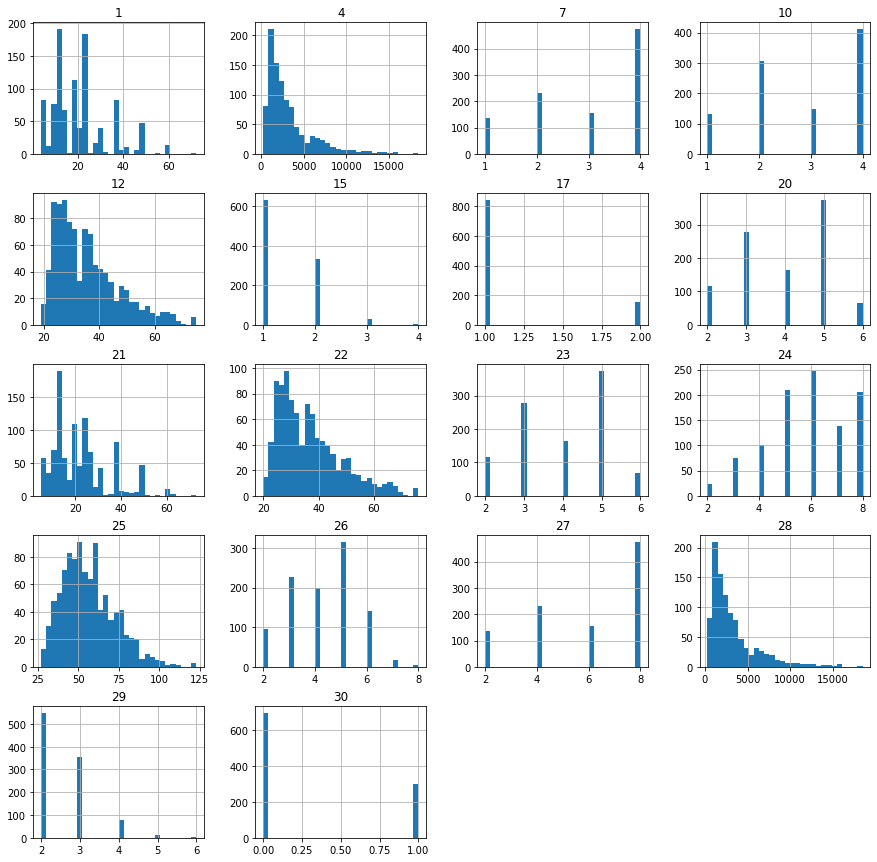

In [204]:
# Plot histograms of dataframe columns

df.hist(bins=30, figsize=(15, 15))
plt.show()

There are outliers in variables 21, 4, and others. Further we will check outliers that deviates more than 3 times the standard deviation

In [205]:
# Describe the main statistics of the dataframe columns

df.describe()

,1,4,7,10,12,15,17,20,21,22,23,24,25,26,27,28,29,30
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,4.000000,22.31000,36.701000,4.000000,5.818000,56.44900,4.252000,5.946000,3306.804000,2.562000,0.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,1.176173,12.06613,11.423927,1.176173,1.609804,16.27582,1.290799,2.237429,2823.131934,0.714609,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,2.000000,5.00000,20.000000,2.000000,2.000000,27.00000,2.000000,2.000000,291.000000,2.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,3.000000,13.00000,28.000000,3.000000,5.000000,44.00000,3.000000,4.000000,1403.250000,2.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,4.000000,19.00000,34.000000,4.000000,6.000000,54.00000,4.000000,6.000000,2352.000000,2.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,5.000000,26.00000,43.000000,5.000000,7.000000,67.00000,5.000000,8.000000,3999.000000,3.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,6.000000,73.00000,76.000000,6.000000,8.000000,123.00000,8.000000,8.000000,18456.000000,6.000000,1.000000


Variables as 4 and 28 have large values, then it could generate noise to the future models. It could be a good idea to scale variables to compare the results further.  

## 1.0 Preprocessing

### 1.0.0 Scaling data

It is known that scaled data could retrieve better results in key metrics of models

In [206]:
# Separate numerical columns from the categorical ones to scale

# Get the numeric columns (integer values due to the dataframe doesn't contains float values)

numeric_columns=[column_type[0] for column_type in zip(df.columns.tolist(), df.dtypes.tolist()) if column_type[1]=='int64']
numeric_columns.remove('30')


# Get categorical columns 

categorical_columns=[column_type[0] for column_type in zip(df.columns.tolist(), df.dtypes.tolist()) if column_type[1]=='object']

# Normalize with min and max of each column

num_df=df[numeric_columns]
num_df_norm=(num_df-num_df.min())/(num_df.max()-num_df.min())

scaled_df=pd.concat((num_df_norm, df[categorical_columns], df['30']),1)

C:\Users\nicol\AppData\Local\Temp\ipykernel_9516\3955588971.py:18: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  scaled_df=pd.concat((num_df_norm, df[categorical_columns], df['30']),1)


In [207]:
# The dataframe is scaled!

scaled_df

,1,4,7,10,12,15,17,20,21,22,...,6,8,9,11,13,14,16,18,19,30
0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,0.75,0.044118,0.857143,...,A75,A93,A101,A121,A143,A152,A173,A192,A201,0
1,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0.25,0.647059,0.053571,...,A73,A92,A101,A121,A143,A152,A173,A191,A201,1
2,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,0.75,0.117647,0.553571,...,A74,A93,A101,A121,A143,A152,A172,A191,A201,0
3,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1.00,0.558824,0.482143,...,A74,A93,A103,A122,A143,A153,A173,A191,A201,0
4,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,1.00,0.308824,0.625000,...,A73,A93,A101,A124,A143,A153,A173,A191,A201,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.117647,0.081765,0.666667,1.000000,0.214286,0.000000,0.0,0.75,0.117647,0.214286,...,A74,A92,A101,A121,A143,A152,A172,A191,A201,0
996,0.382353,0.198470,1.000000,1.000000,0.375000,0.000000,0.0,0.75,0.382353,0.375000,...,A73,A91,A101,A122,A143,A152,A174,A192,A201,0
997,0.117647,0.030483,1.000000,1.000000,0.339286,0.000000,0.0,0.75,0.117647,0.339286,...,A75,A93,A101,A123,A143,A152,A173,A191,A201,0
998,0.602941,0.087763,1.000000,1.000000,0.071429,0.000000,0.0,0.75,0.602941,0.071429,...,A73,A93,A101,A124,A143,A153,A173,A192,A201,1


### 1.0.1 Check outliers

Outliers can generate noise to the models, so it is important to remove them

In [76]:
no_outliers_df=scaled_df

# define numbers of standard deviations to filter
number_stds=3

for column in no_outliers_df.columns:
    # Only of numerical columns
    if no_outliers_df[column].dtype=='int64':
        
        # Get mean and standard deviation
        
        mean=no_outliers_df[column].mean()
        std=no_outliers_df[column].std()
        
        # Filter at most 3 standard deviation distance from the mean
        
        no_outliers_df=no_outliers_df[(no_outliers_df[column]>mean-(number_stds*std)) & (no_outliers_df[column]<mean+(number_stds*std))]

print(len(no_outliers_df))

1000


There is no outliers that exceed 3 times the std 

## 1.1 Behavior of default by variables

In this step we will explore the relation between each column and its effect and significance in the default variable

In [202]:
def plotMeansAndQs(dataFrame=df, columnName='1', targetColumn='30'):
    """
    Plots the means of the target column by value of column
        dataFrame: pandas DataFrame containing the data
        targetColumn: String containing the target column name 
        columnName: String containing the column name
    """
    
    fig, ax = plt.subplots(figsize=(20,8))
    
    # Get categories or unique values
    
    uniqueValues=dataFrame[columnName].unique().tolist()
    

    # Order if the variable is numeric
    
    if dataFrame[columnName].dtype=='int64':
        uniqueValues.sort()

    # Set count annotation below xAxis
    
    ax.text(-2, -.1, 'Count')
    
    # plot bars or scatter depending on the number of unique values
    
    # iterate over each value
    
    for i, value in zip(range(0,len(uniqueValues)), uniqueValues):
        
        # filter the dataframe containing the value
        
        filteredDataFrame=dataFrame[dataFrame[columnName]==value][targetColumn]
        
        # get the mean of the default/payment column of value
        
        meanTargetValue=filteredDataFrame.mean()
        
        # if there is not too much values to plot, plot bars, else plot points and don't annotate customer quantities (scatter)
        if len(uniqueValues)<500:
            ax.bar(i, meanTargetValue, color=plt.cm.Reds(meanTargetValue))
            ax.text(i-.1, -.1, filteredDataFrame.count())    
            
        else:
            ax.scatter(i, meanTargetValue, color=plt.cm.Reds(meanTargetValue))

    # set xticks 
    
    if len(uniqueValues)<500:
        plt.xticks(ticks=np.arange(i+1), labels=uniqueValues)
        
    # hide axis borders 
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # set title
    
    ax.set_title(f"Column {targetColumn} means by column {columnName} values")
    return

C:\Users\nicol\AppData\Local\Temp\ipykernel_9516\1940161671.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(20,8))


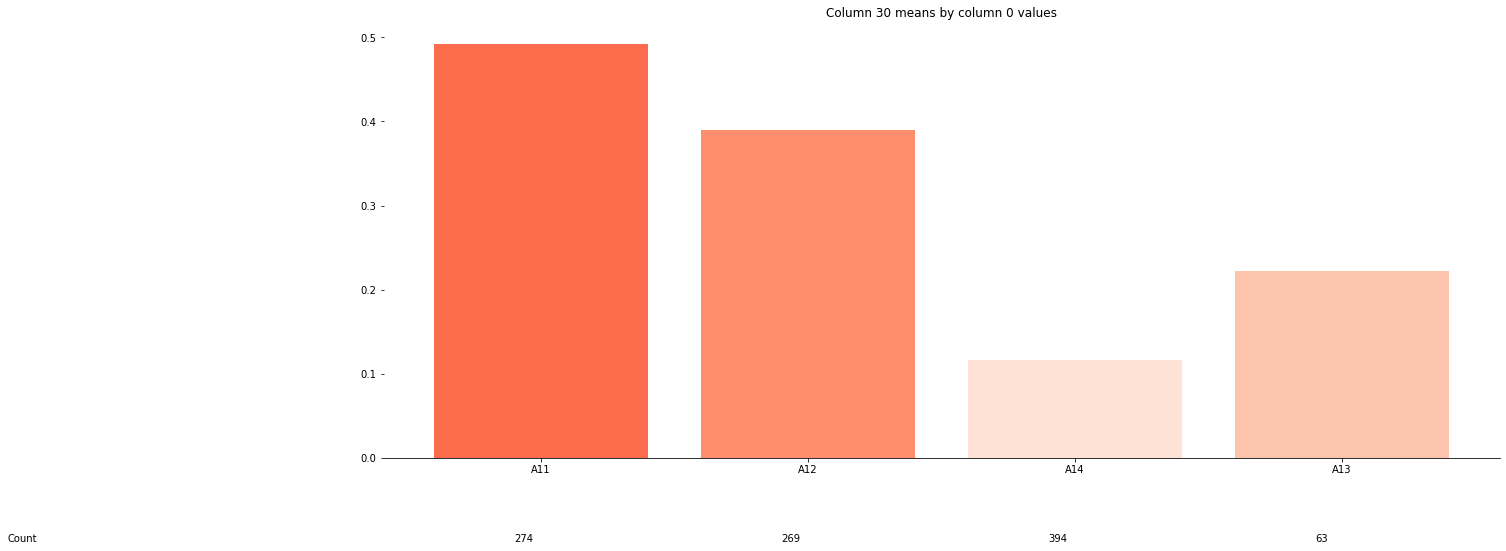

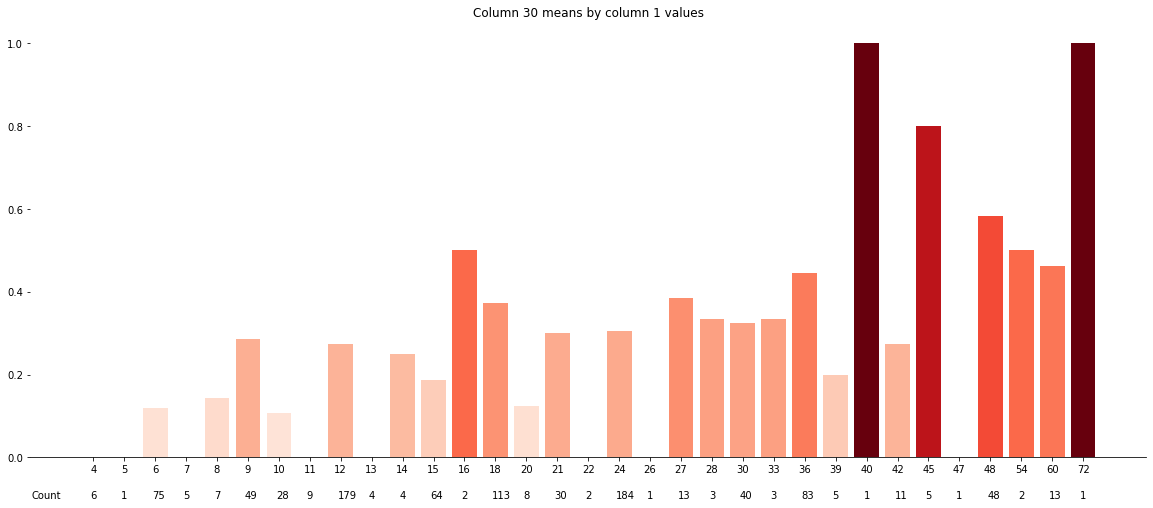

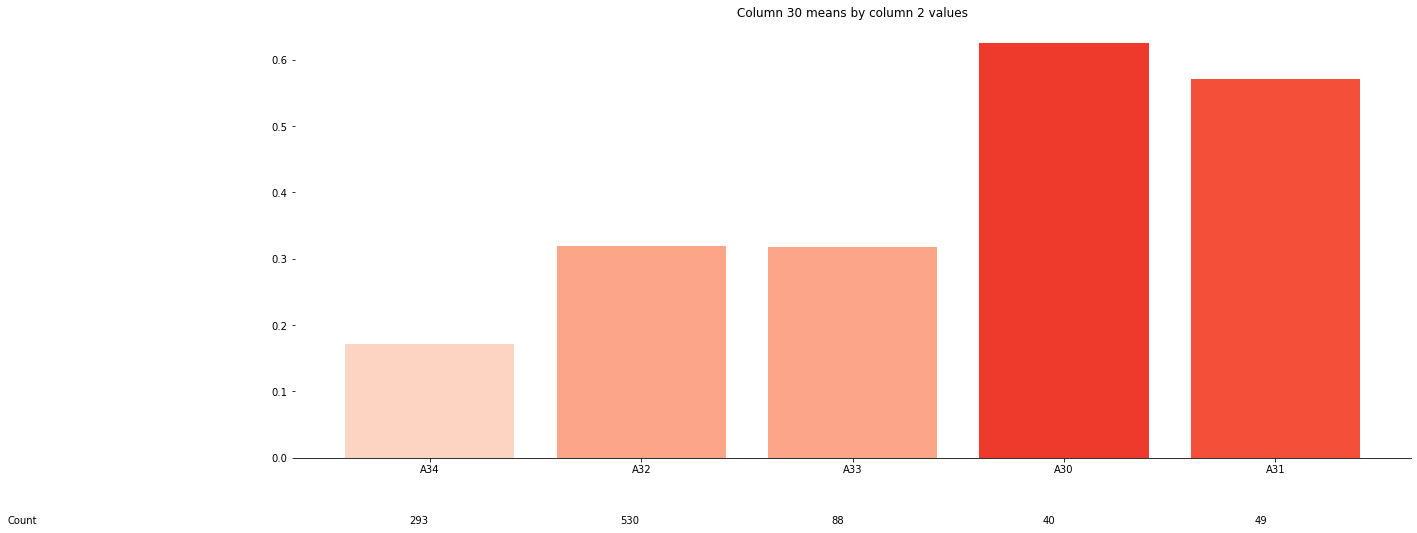

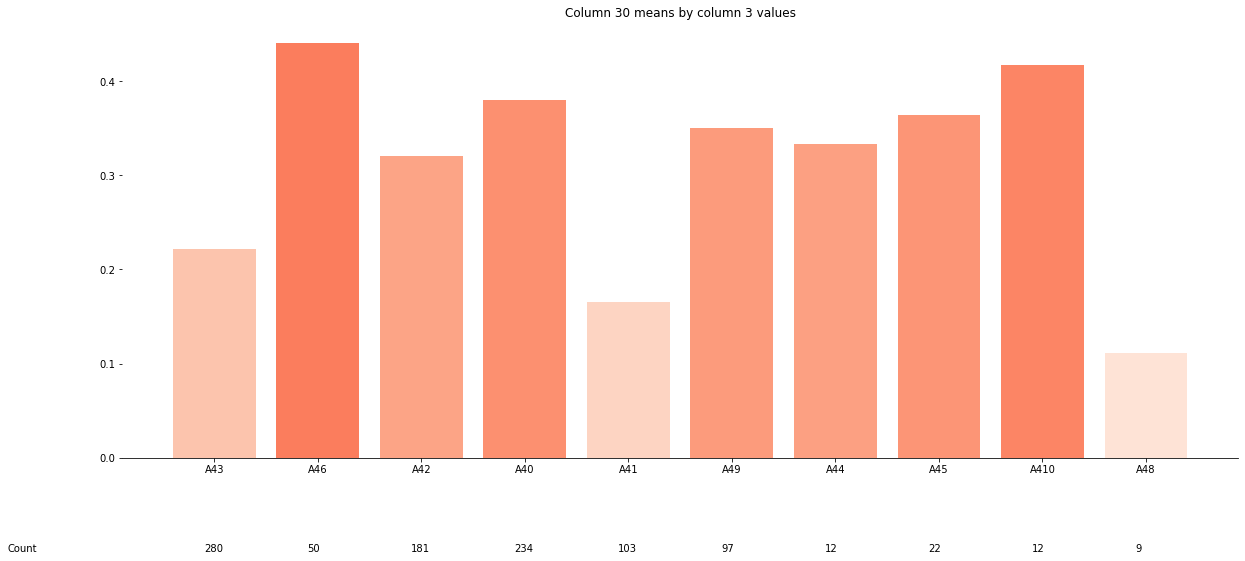

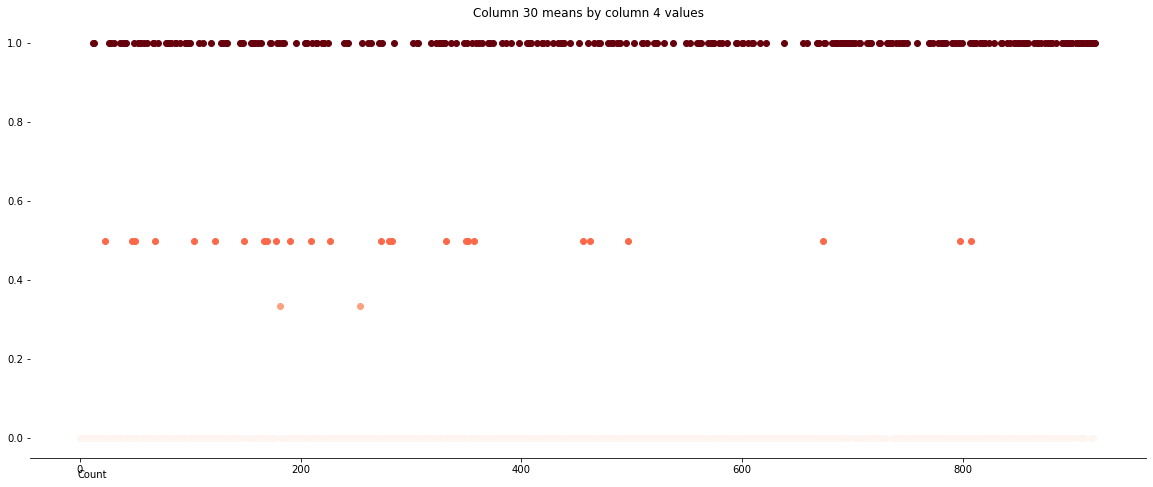

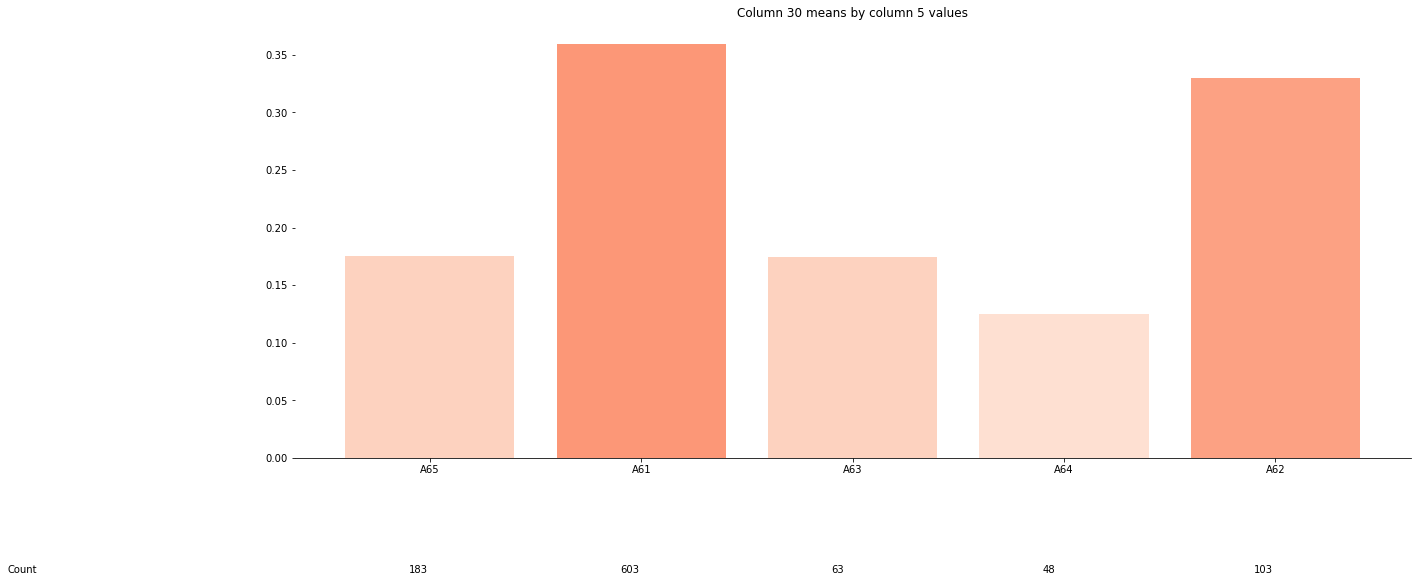

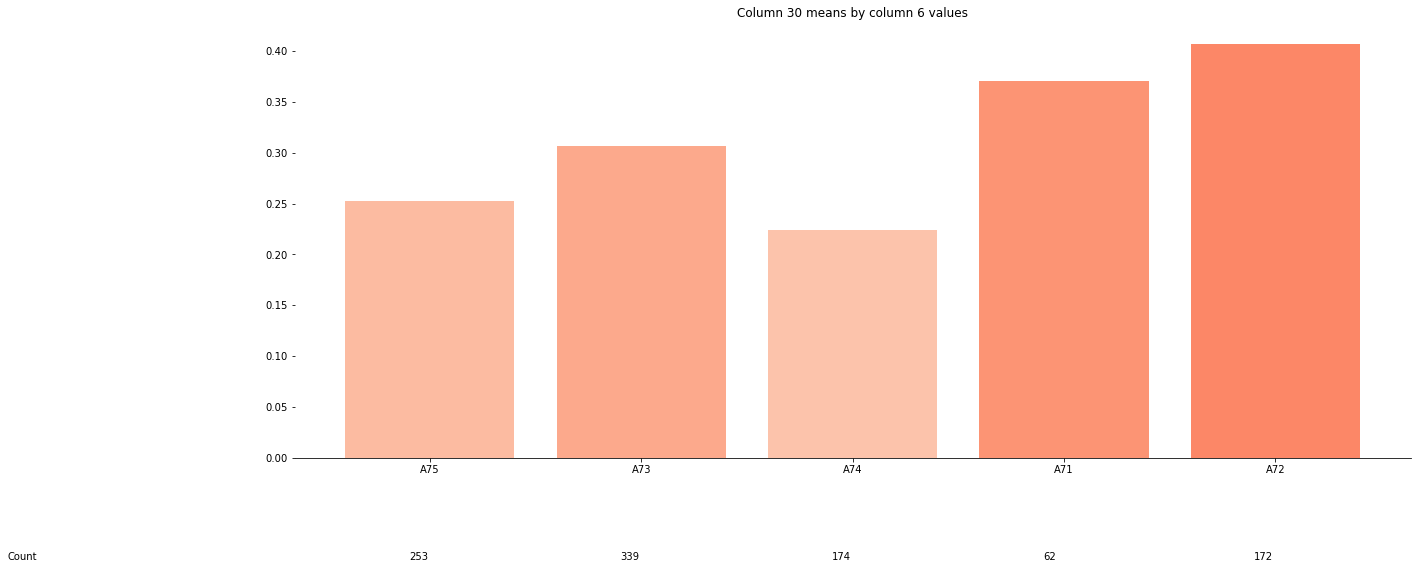

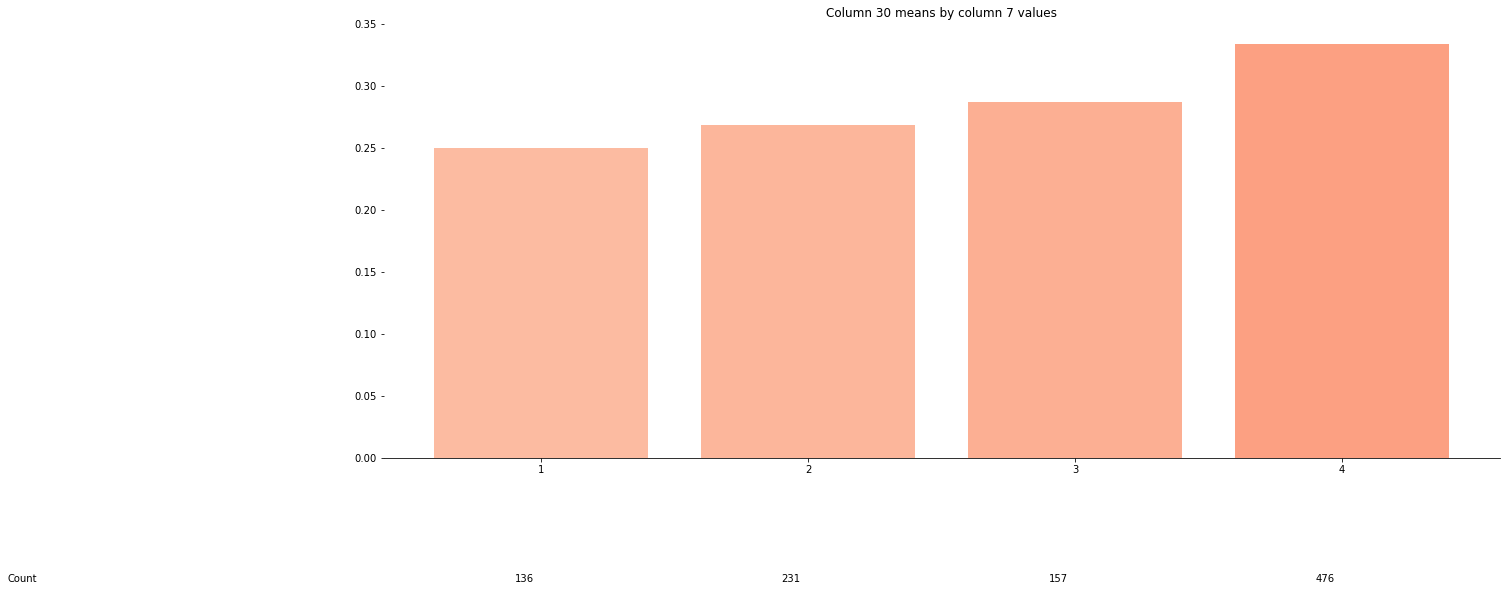

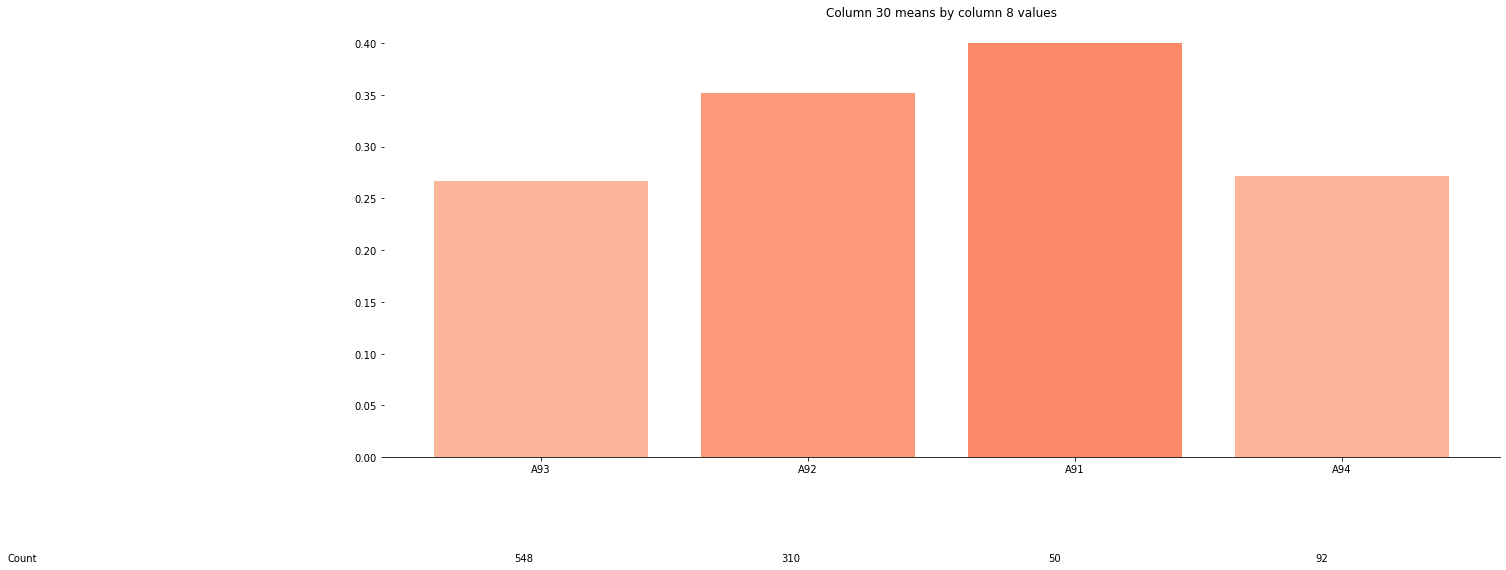

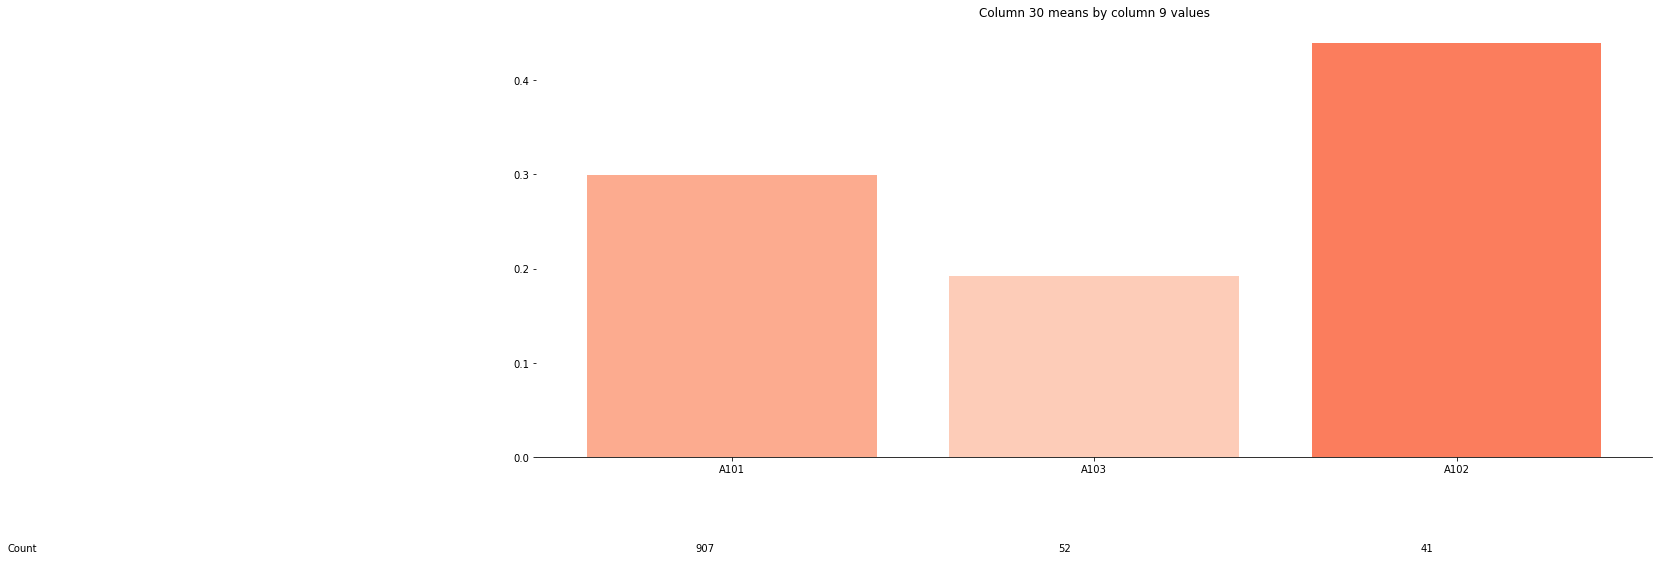

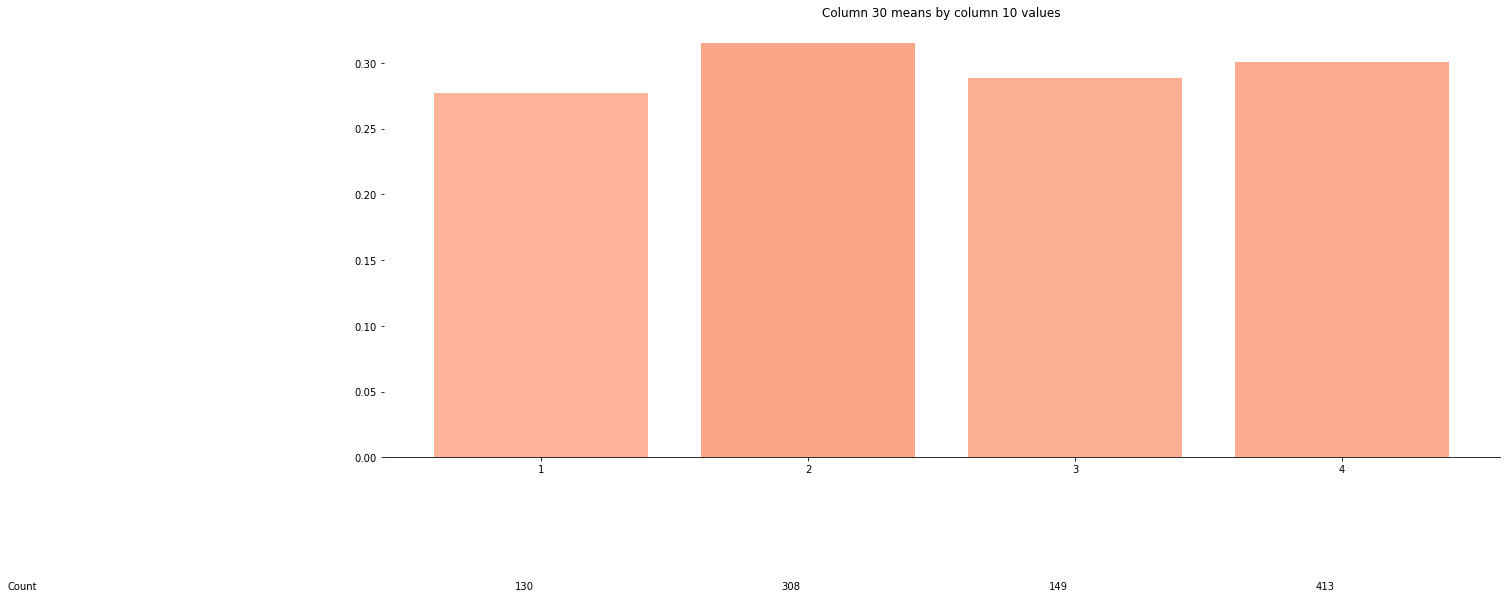

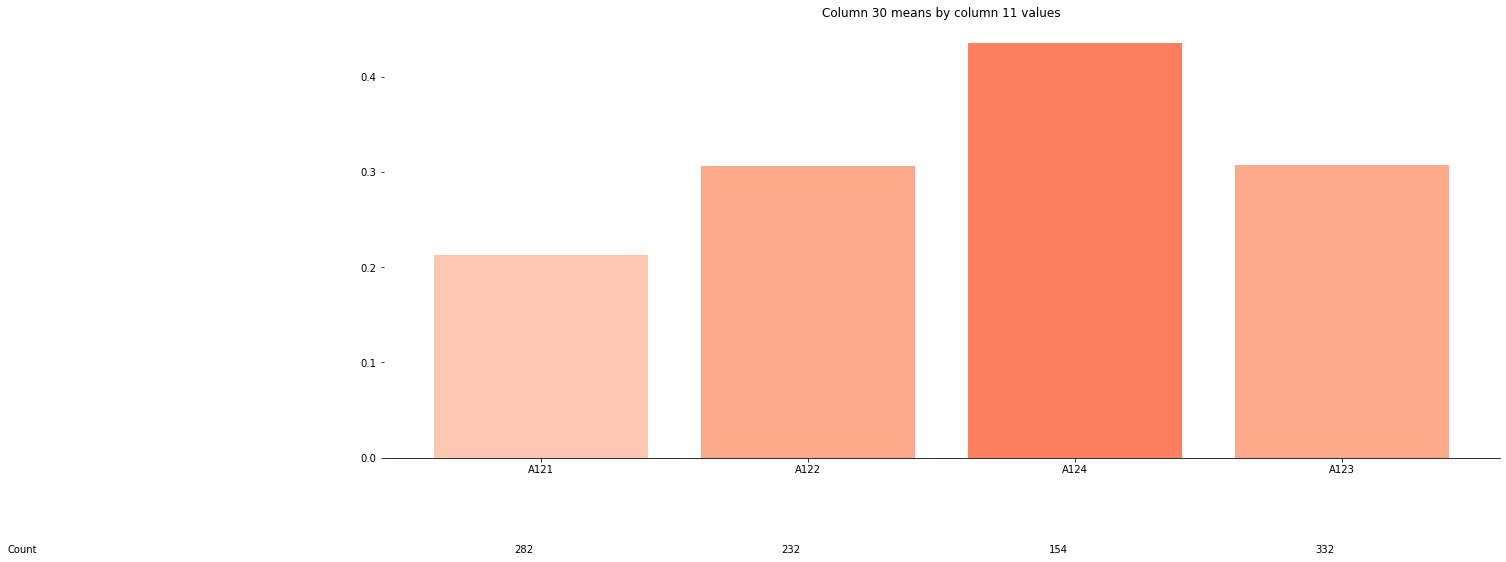

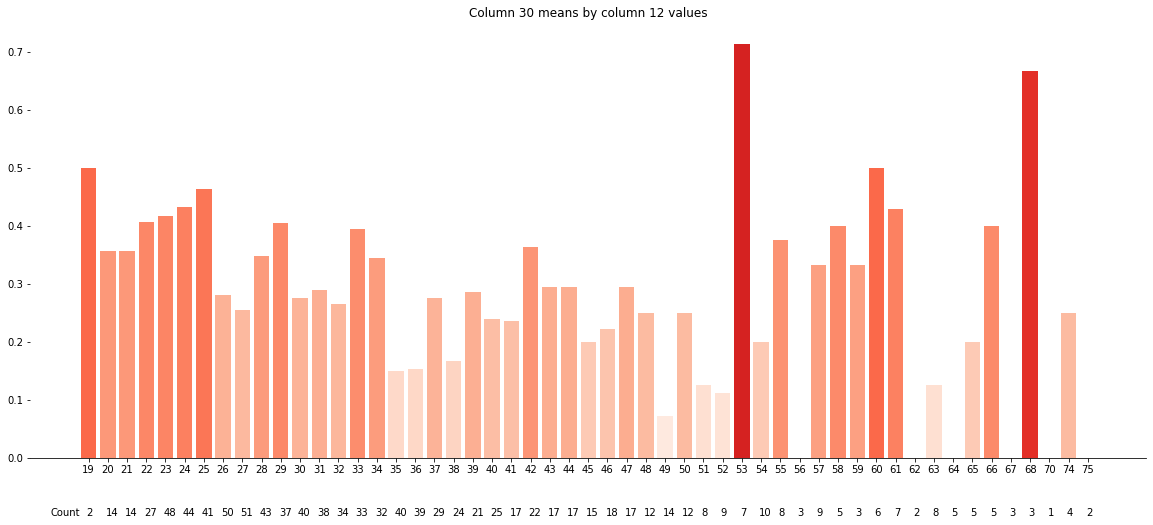

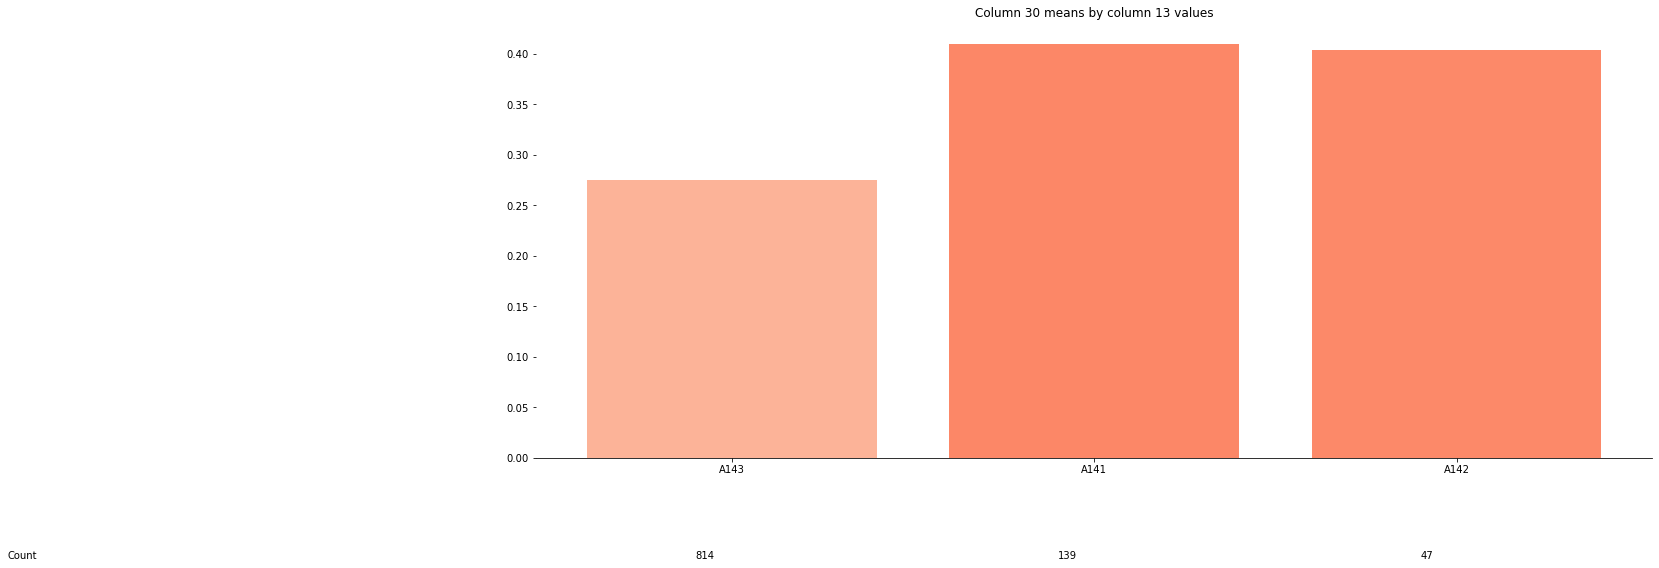

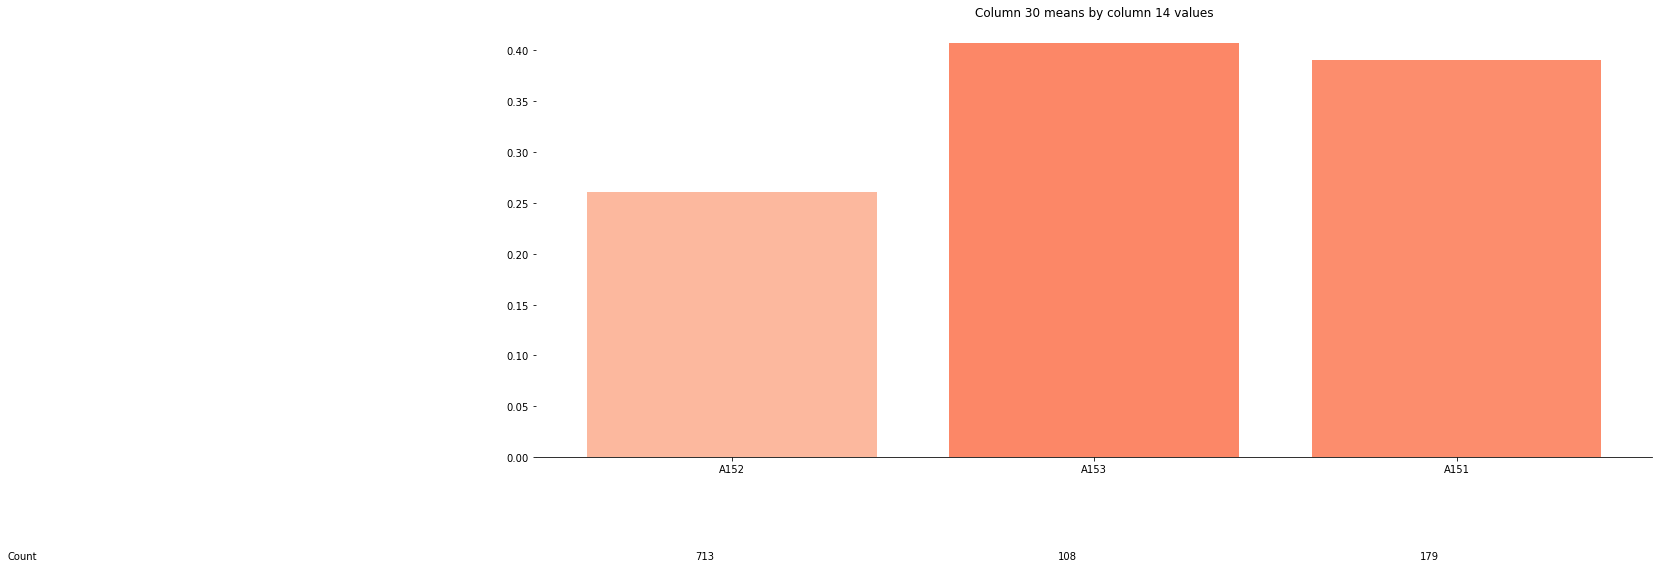

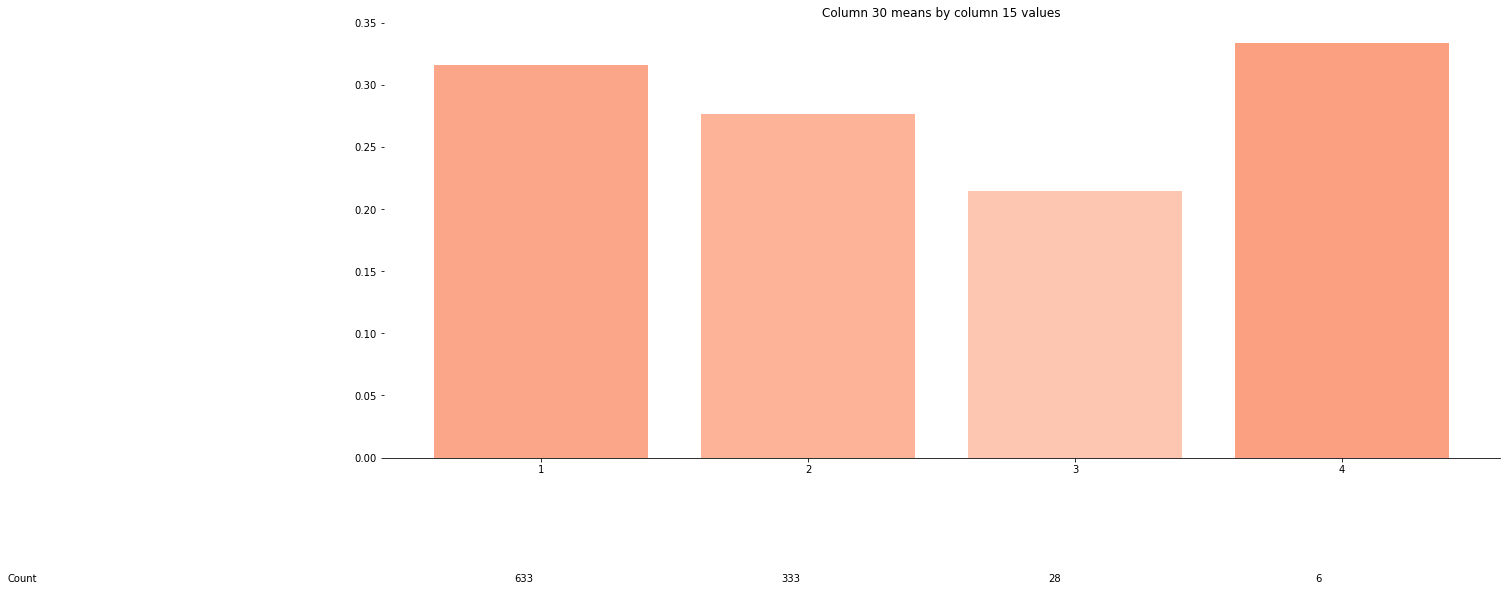

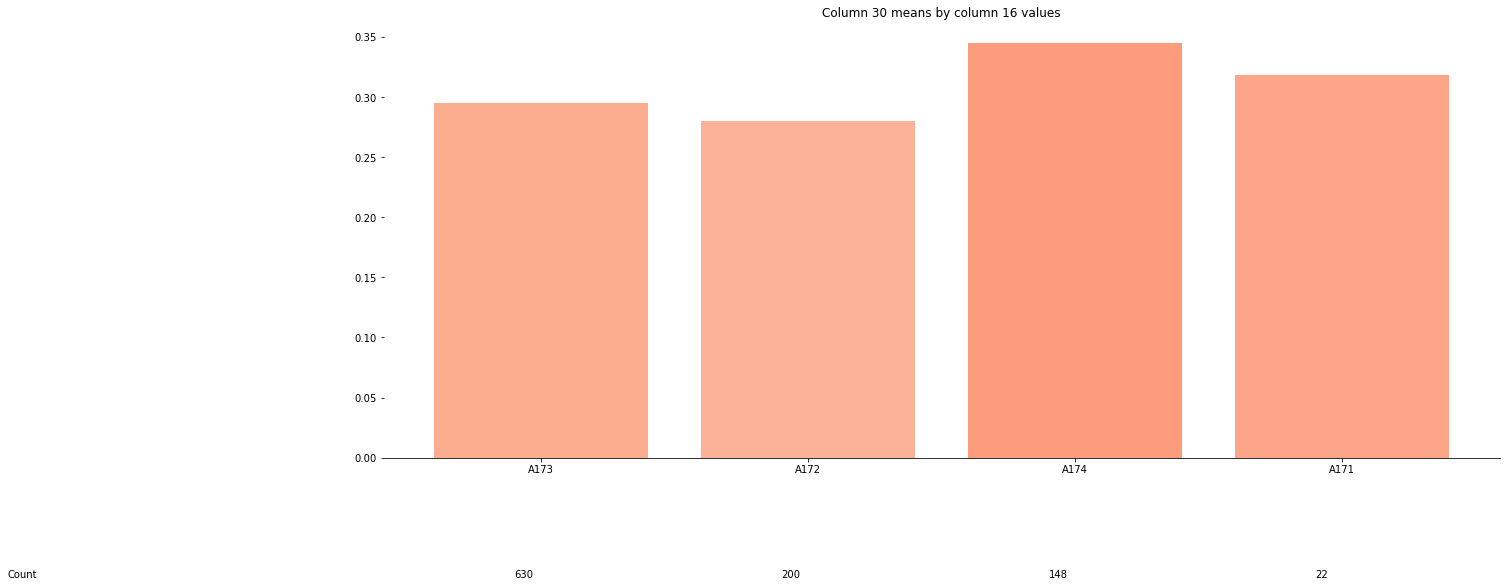

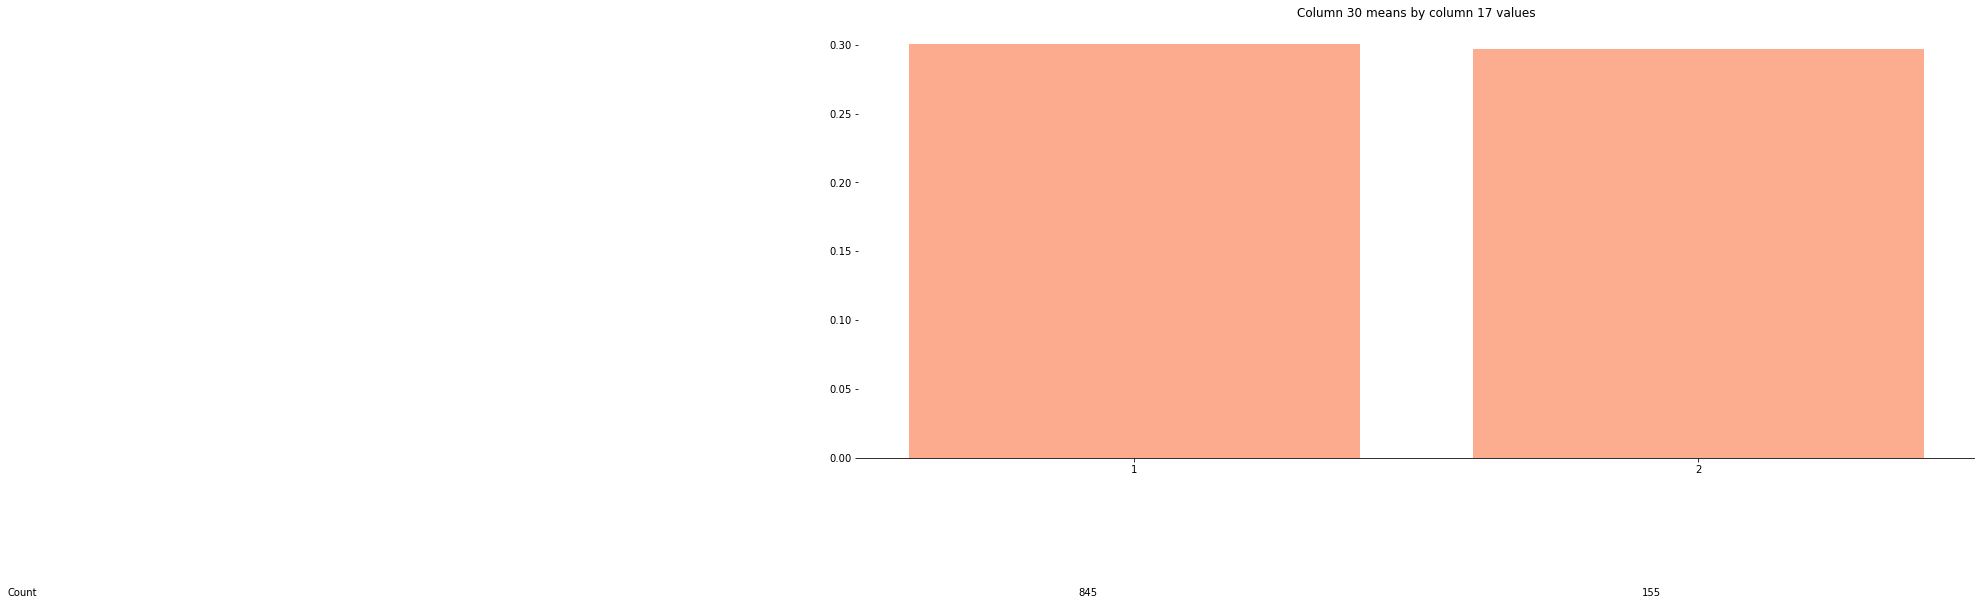

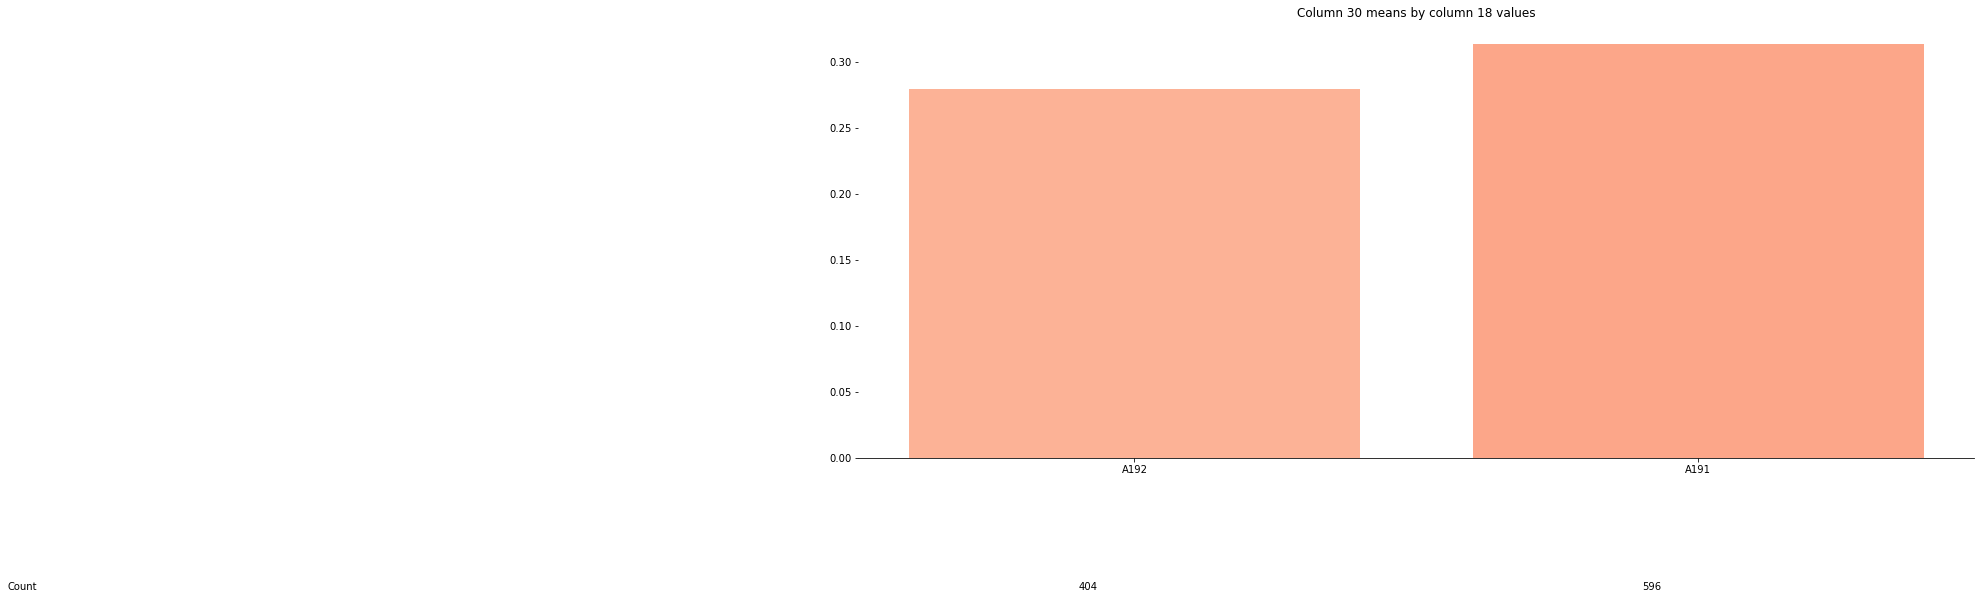

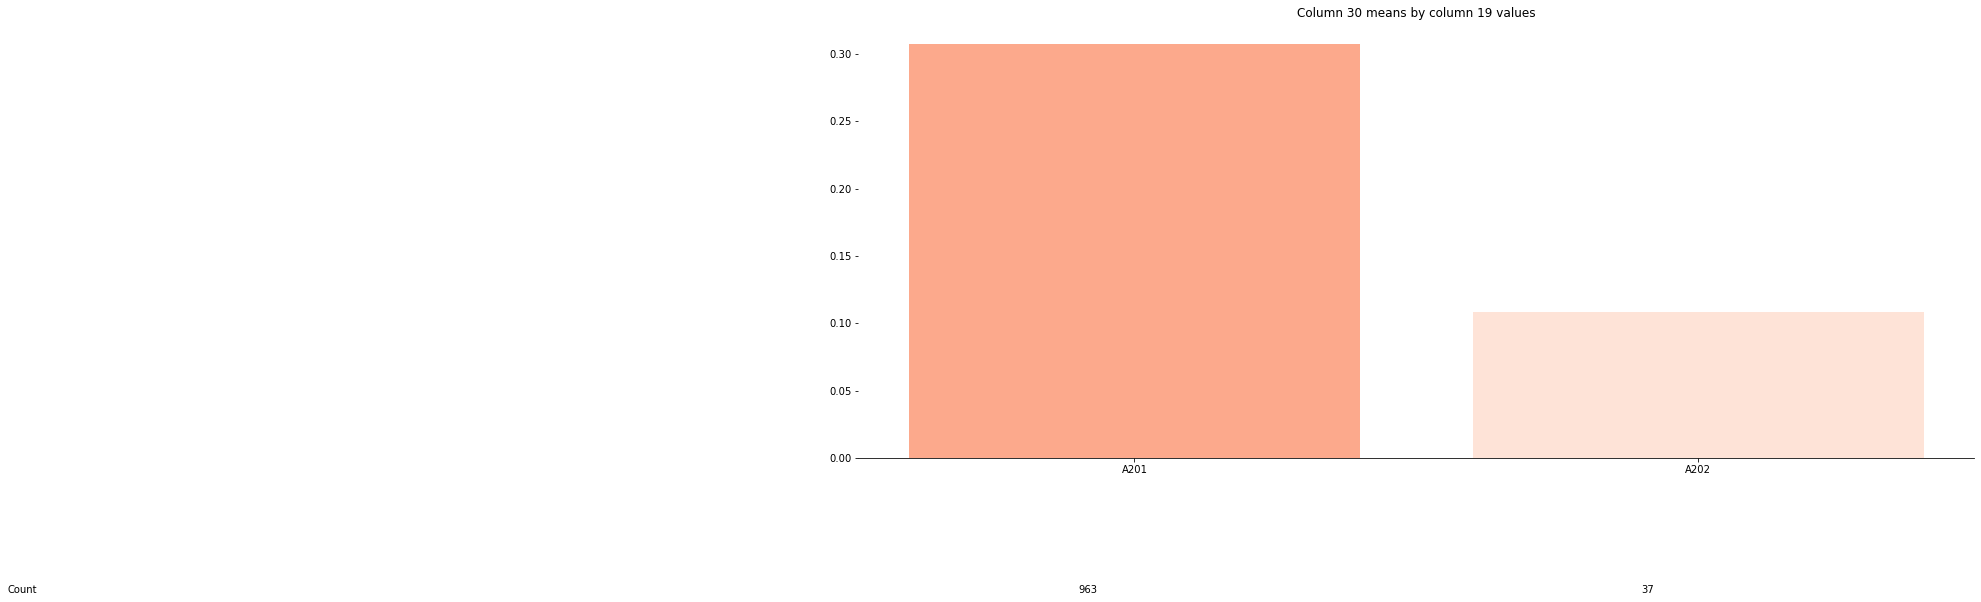

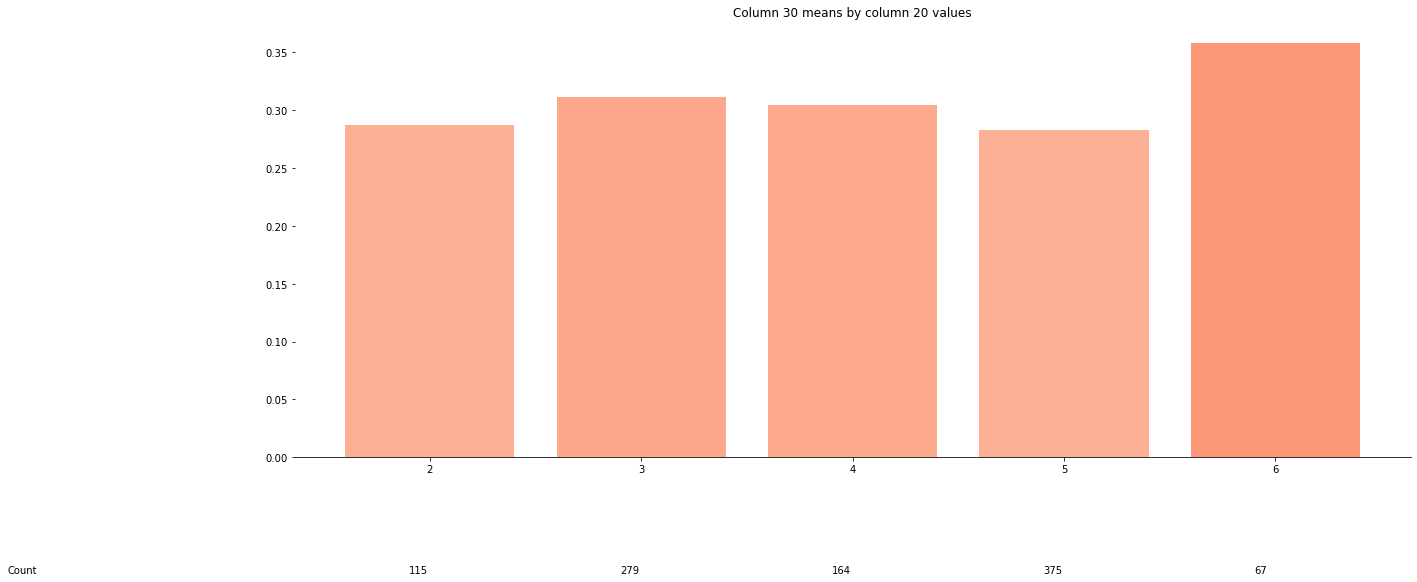

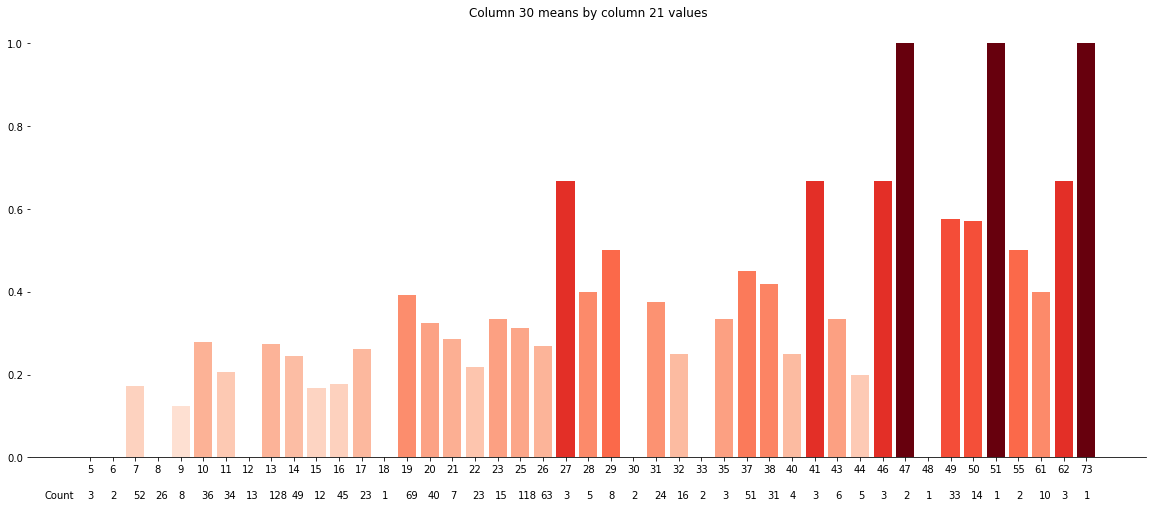

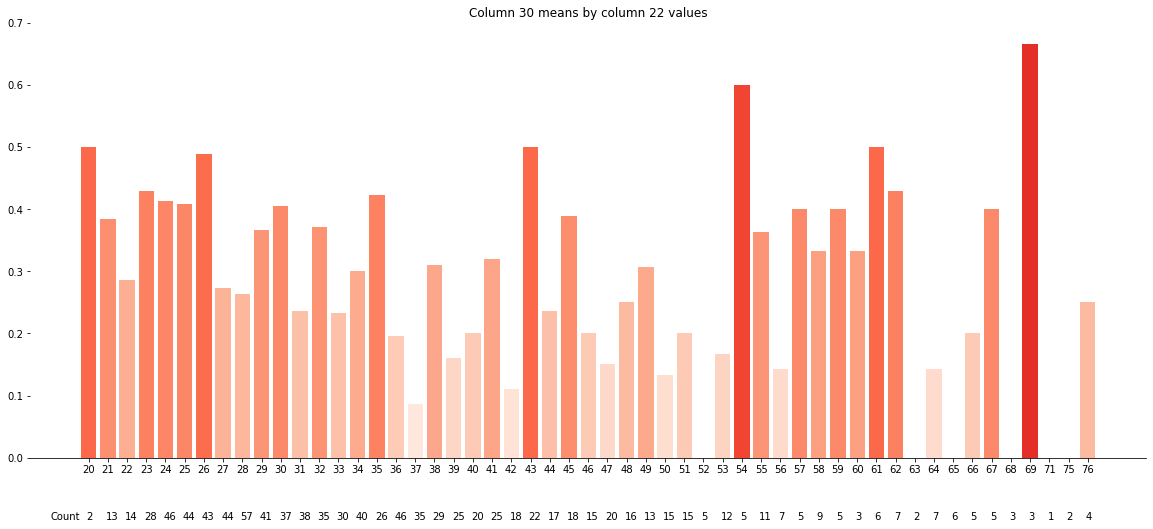

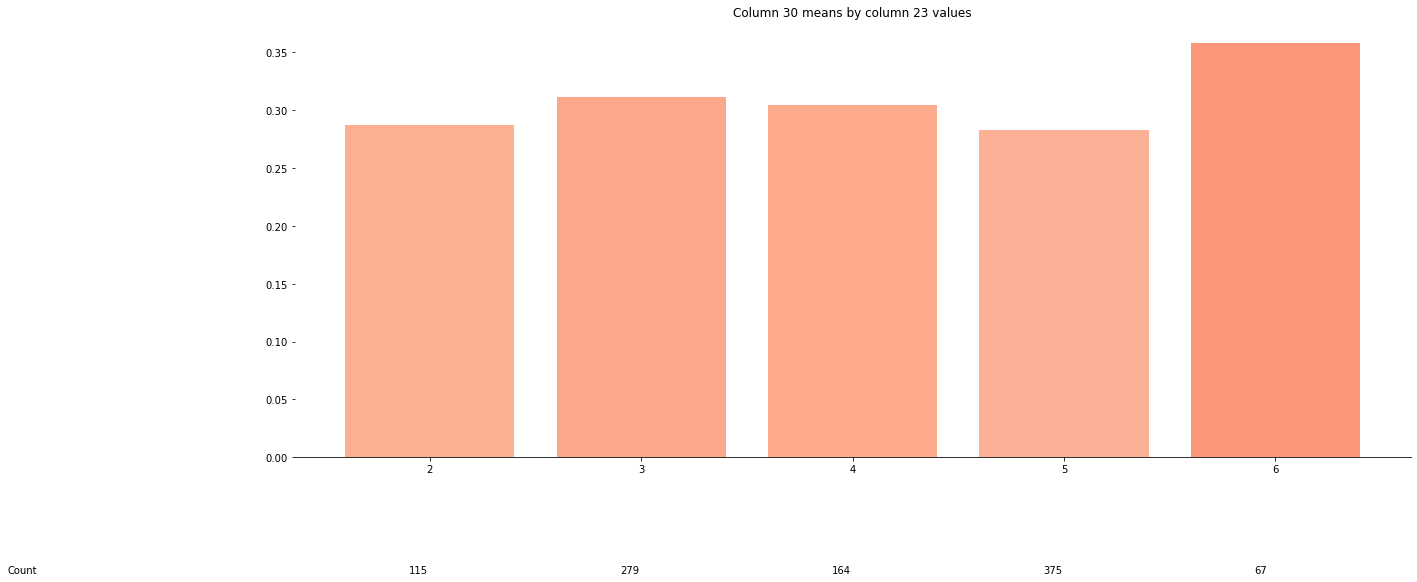

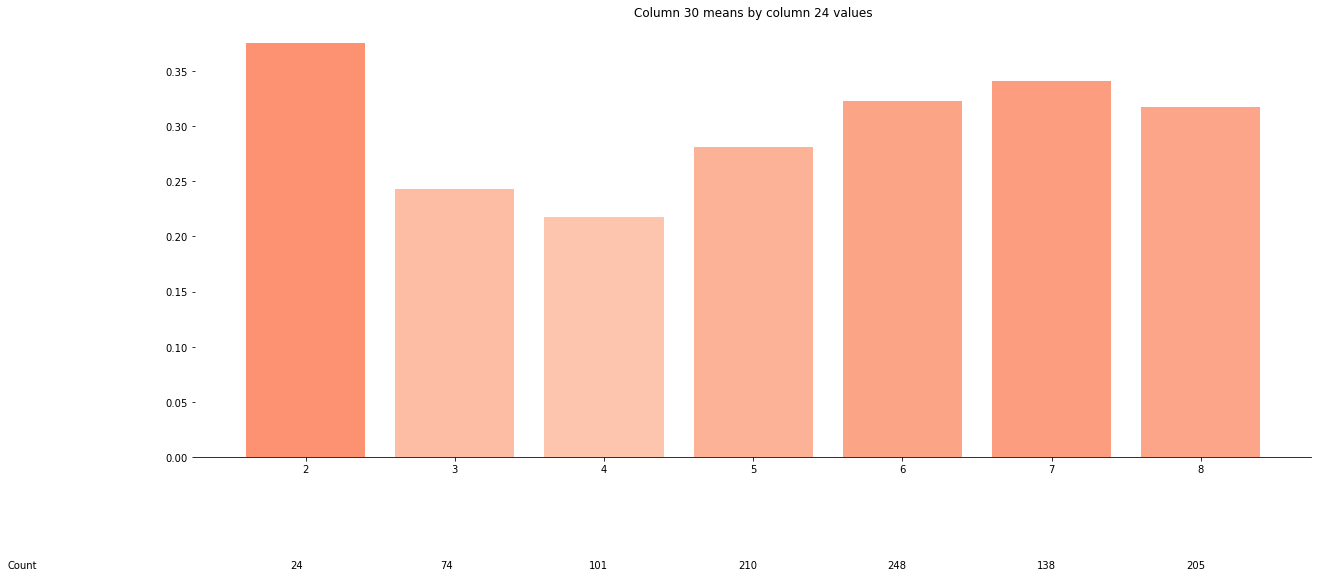

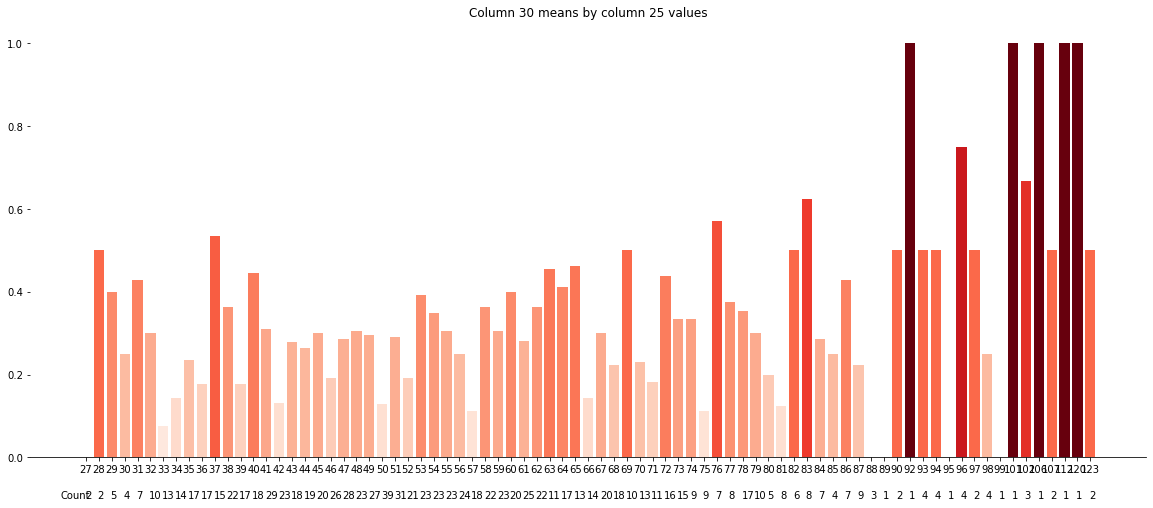

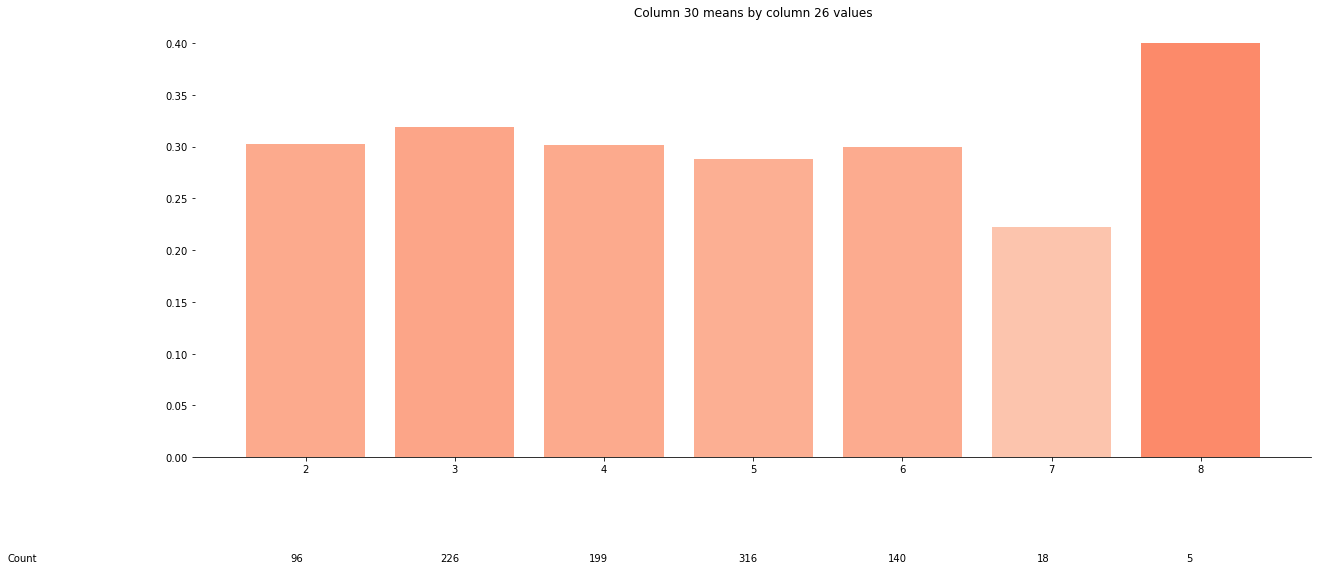

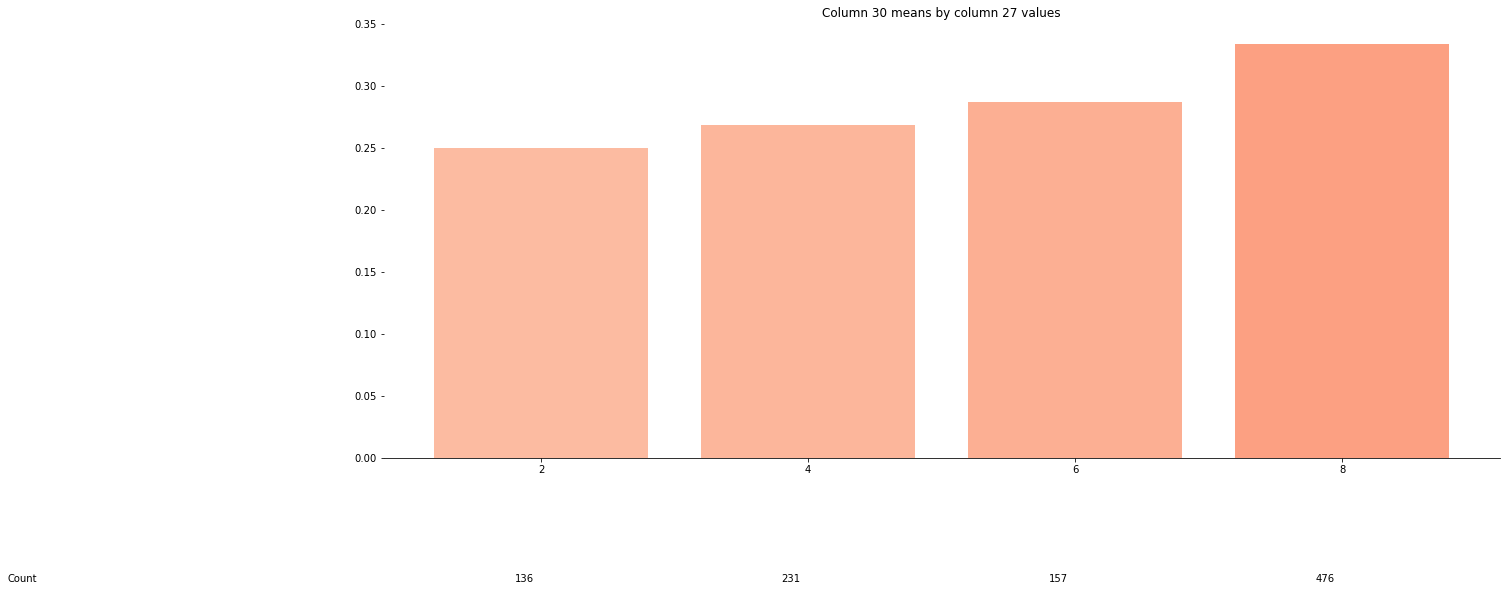

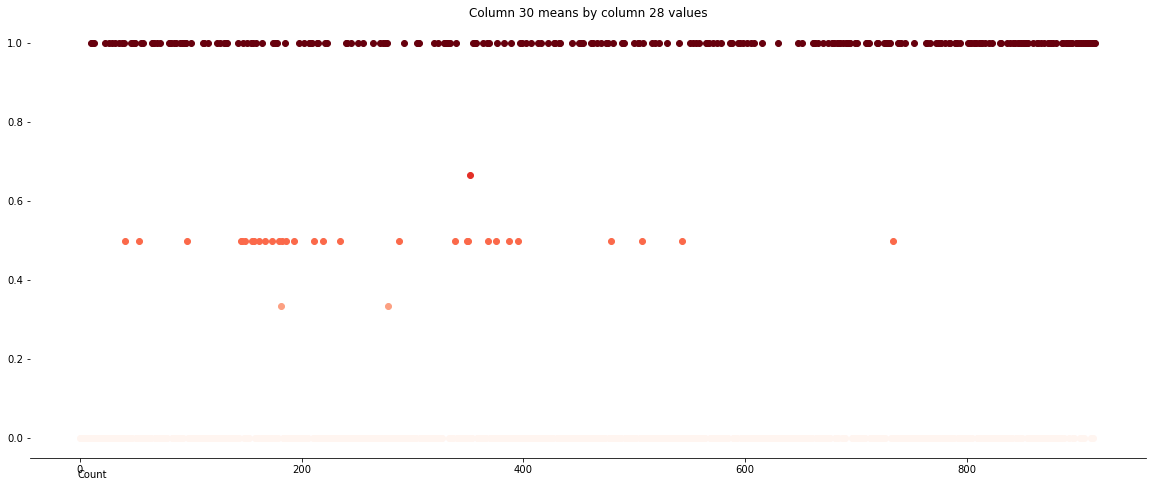

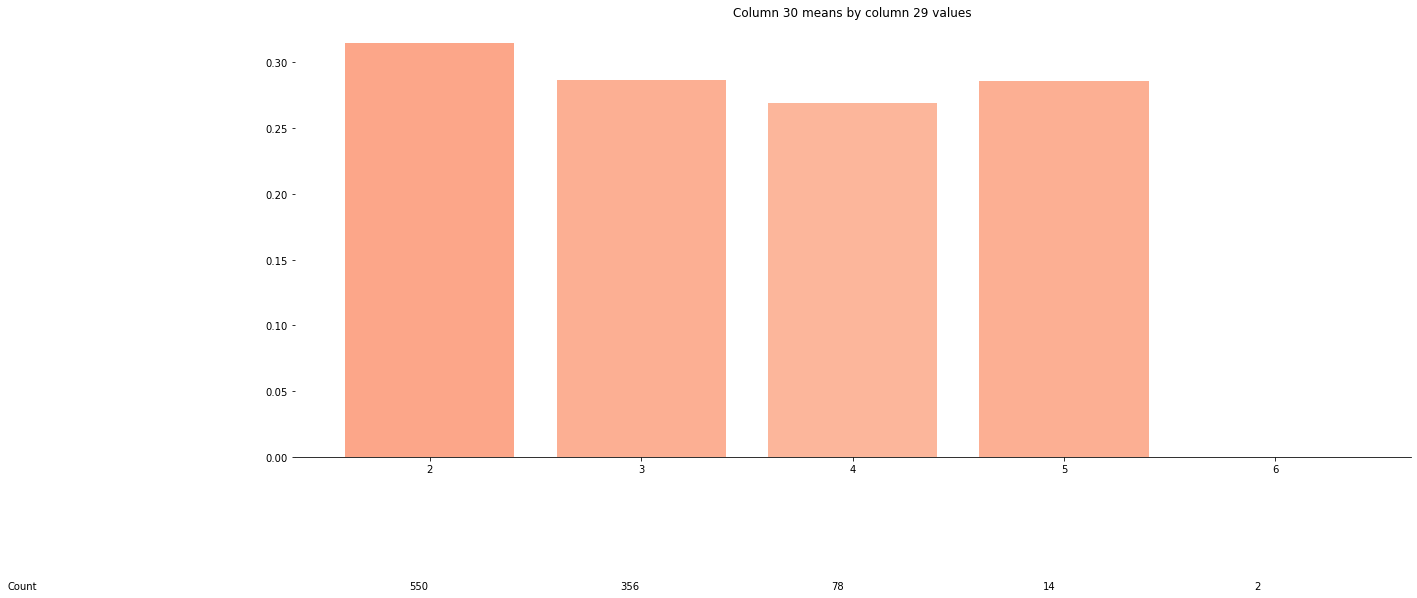

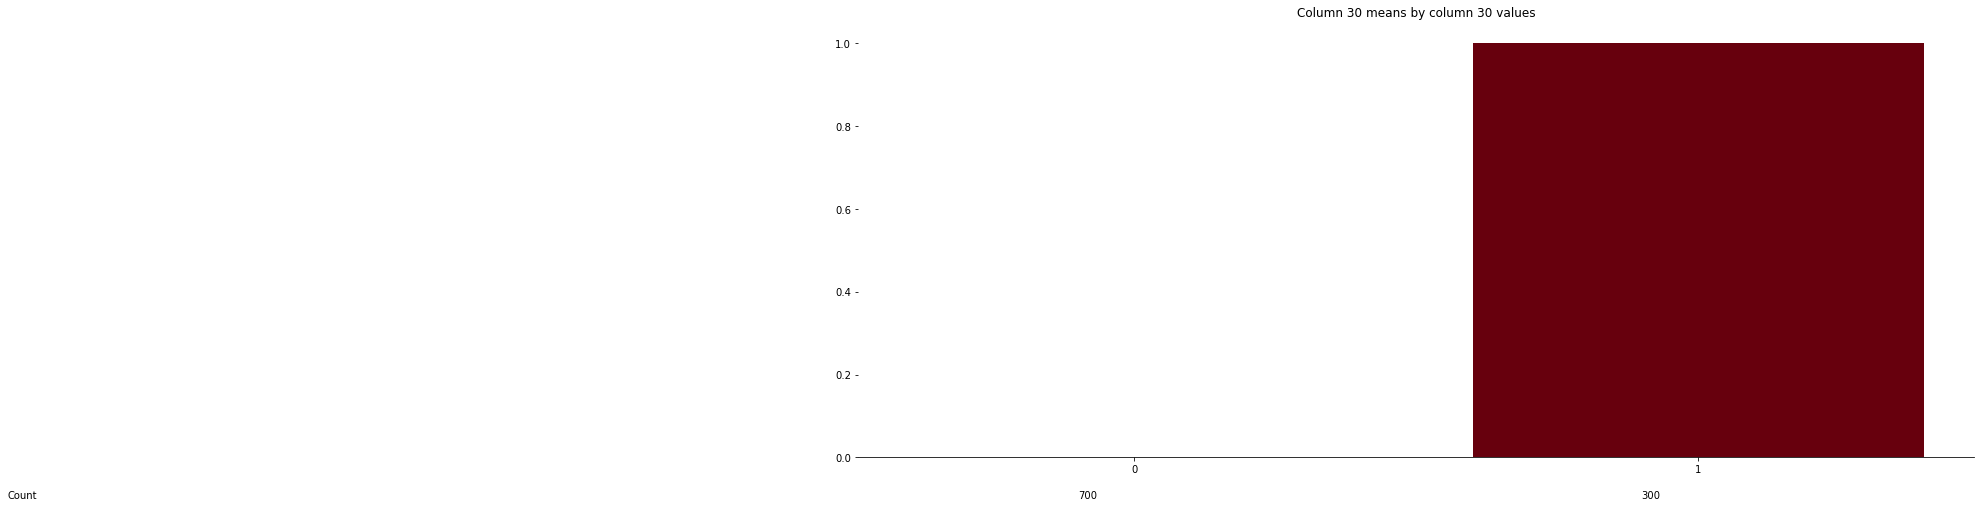

In [208]:
# now, plot every column 

for column in df.columns:
    plotMeansAndQs(columnName=column)

## 1.1.1 Observations
Thanks to the previous plots we can already have an idea of the effects of each variable

- [x] Column 0 A11 and A12 categories have higher payment rates than the others
- [x] Column 1 seems to have a positive effect in the credit payment
- [x] Column 2 A30 and A31 categories have higher payment rates than others, but low Q
- [x] Column 3 A43, A41 and A48 have lower rates than the other categories
- [x] Column 5 A61 and A62 have higher rate than other categories
- [x] Column 7 has a positive tendency, but the increase rate is low
- [x] Column 8 A92 and A91 have higher rates
- [x] Column 9 A102 has higher rate
- [x] Column 11 A124 has higher rate
- [x] Column 14 A152 has lower rate
- [x] Column 19 A201 has higher rate
- [x] Column 21 seems to have a positive effect in the credit payment
- [x] Column 27 seems to have a slightly positive effect in the credit payment


## 1.2 Correlation between variables
It is important to know what variables are correlated because it could be redundant to consider highly correlated variables in a model

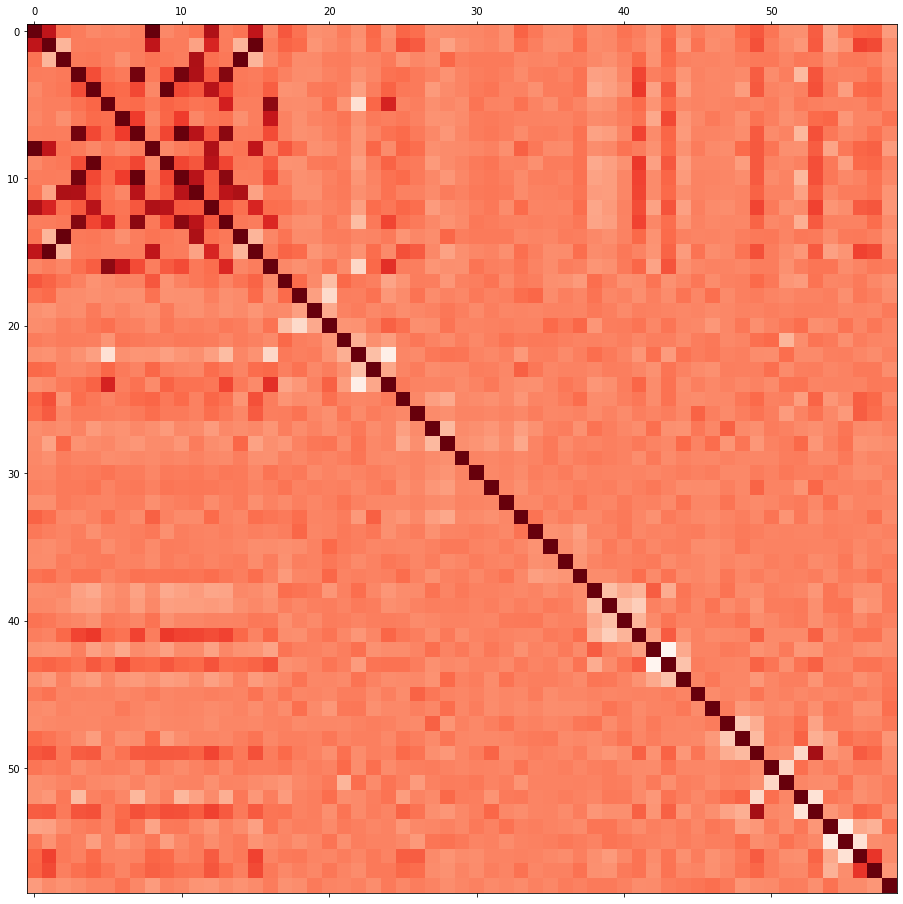

In [48]:
# Generate dummies columns

db=pd.get_dummies(df, drop_first=True)
scaled_df=pd.get_dummies(scaled_df, drop_first=True)

# Correlation matrix

fig, ax =plt.subplots(figsize=(16,16))

ax.matshow(db.corr(), cmap=plt.cm.Reds)
plt.show()

It seems that the correlation is more frequent in the first 20 columns (i.e. categorical values have low correlation)

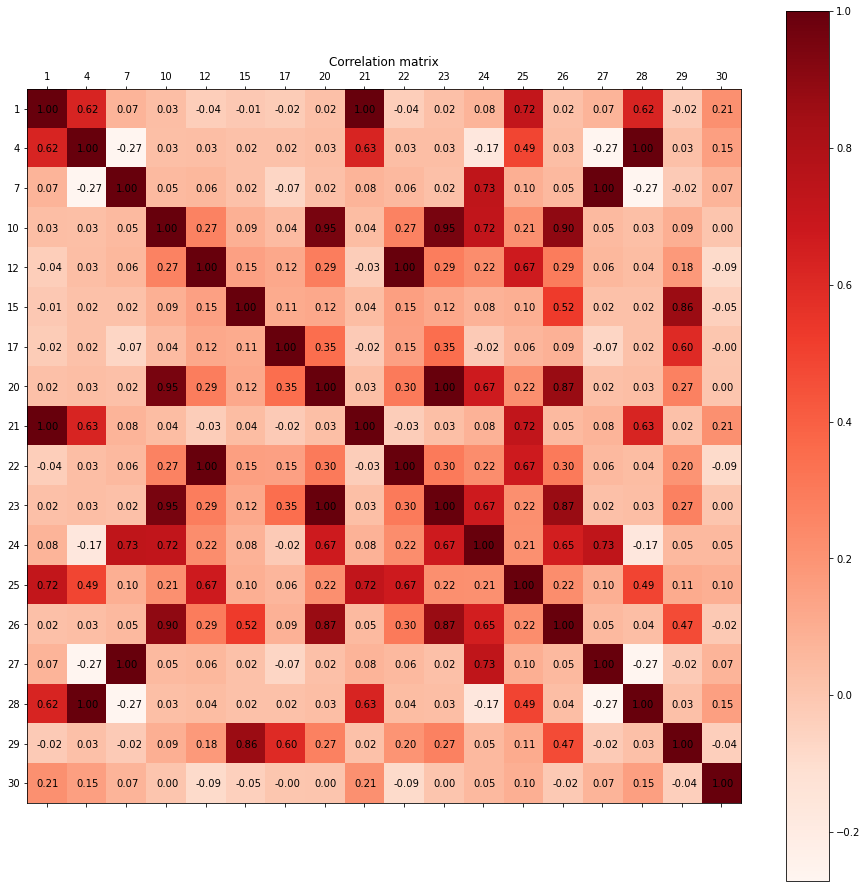

In [33]:
# plot the numerical columns correlation matrix
fig, ax =plt.subplots(figsize=(16,16))

lastColumnIndex=18
corr_matrix=db.corr().iloc[0:lastColumnIndex, 0:lastColumnIndex]
cx=ax.matshow(corr_matrix, cmap=plt.cm.Reds)
ax.set_title("Correlation matrix")
fig.colorbar(cx)
plt.xticks(ticks=np.arange(lastColumnIndex), labels=corr_matrix.columns)
plt.yticks(ticks=np.arange(lastColumnIndex), labels=corr_matrix.columns)

listIteration=np.arange(lastColumnIndex)
for i in listIteration:
    for j in listIteration:
        ax.text(i-.25, j+.1, '{:.2f}'.format(corr_matrix.iloc[i,j]))
    

plt.show()

### 1.2.1 Correlated variables

- [x] Columns 1 and 21, 4 and 28, 7 and 27, 10 and 23, 10 and 20, 12 and 22, 20 and 23 have a correlation near to 1 
- [x] Columns 26 and 10, 29 and 15, 26 and 20, 26 and 23 have a correlation near to 0.9
- [x] Columns 25 and 1, 24 and 7, 24 and 10, 25 and 12, 24 and 20, 21 and 25, 22 and 25, 24 and 27 have a correlation near to 0.7

In [34]:
# filter columns with more than 95% correlation

toDrop=corr_matrix[corr_matrix >= 0.95]

In [209]:
# print toDrop matrix to decide which columns remove

toDrop

,1,4,7,10,12,15,17,20,21,22,23,24,25,26,27,28,29,30
1,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999992,NaN,NaN
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
10,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.951525,NaN,NaN,0.951525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.999505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,0.951525,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,0.998854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,0.999505,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# drop highly correlated columns

columnsToDrop=['21','28','27','20','23','22']

bd=db.drop(columns=columnsToDrop)
scaled_bd=scaled_df.drop(columns=columnsToDrop) 

## 1.3 Missing Values

We check if there are missing values before the modeling step

In [37]:
max(db.isna().sum())==0

# No missing values

True

## 1.4 Proportions

How many customers have paid their credits?

In [38]:
db['30'].value_counts()

0    700
1    300
Name: 30, dtype: int64

- [x] 70% default and 30% no default  

# 2. Modeling 

## 2.1 Is it correct to use a regression for this kind of problems?

It is possible, but not the best model for classification problems. For modeling the risk of default is commonly used non linear models (logit, probit, classification trees). We will try different models
- [x] Logistic and Probit Regressions

Only if I have time:
- [x] Classification Trees
- [x] K-Nearest Neighbors

## 2.2 Test and train split

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

SEED=123

features=db.columns.tolist()
features.remove('30')

X, y=db[features], db['30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)

# Split for dataframe without highly correlated columns

non_corr_features=bd.columns.tolist()
non_corr_features.remove('30')

non_corr_X, non_corr_y=bd[non_corr_features], bd['30']

non_corr_X_train, non_corr_X_test, non_corr_y_train, non_corr_y_test = train_test_split(non_corr_X, non_corr_y, test_size=.2, random_state=SEED)

# Split for scaled dataframe

scaled_features=scaled_bd.columns.tolist()
scaled_features.remove('30')

scaled_X, scaled_y=scaled_bd[scaled_features], scaled_bd['30']

scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test = train_test_split(scaled_X, scaled_y, test_size=.2, random_state=SEED)

## 2.3 Logistic Regression

Logistic regression is commoly used for predicting yes/no results 

In [42]:
import warnings 

# train the model

with warnings.catch_warnings(record=True):
    lr=LogisticRegression(random_state=SEED)
    lr.fit(X_train, y_train)

In [50]:
# predict test and train values

y_train_pred_lr=lr.predict(X_train)
y_test_pred_lr=lr.predict(X_test)

print("Train accuracy score : {}".format(accuracy_score(y_train, y_train_pred_lr)))
print("Test accuracy score : {}".format(accuracy_score(y_test, y_test_pred_lr)))

Train accuracy score : 0.7425
Test accuracy score : 0.7


As the accuracy is better in the train set it could be sign of overfitting

In [44]:
# Stratified cross validation ... 
with warnings.catch_warnings(record=True):
    lr_cvScore=cross_val_score(lr, X, y)
    print(lr_cvScore)

[0.735 0.68  0.745 0.735 0.72 ]


The accuracy varies from 68% to 74%. 

### 2.3.1 Feature selection

Let's see which features the model chose

In [210]:
def showFeatures(names, coefficients, title):
    """
    Plot feature coefficients ordered in decreasing order
    
        coefficients (list) : the coefficients
        names (list) : the feature names
        title (string) : title of the plot
        
    """
    fig, ax =plt.subplots(figsize=(10,20))
    
    name_coef_list=[[name, abs(coef), coef] for name, coef in zip(names, coefficients)]
    
    name_coef_list.sort(key=lambda row: row[1], reverse=False)
    
    ax.barh([row[0] for row in name_coef_list], [row[2] for row in name_coef_list])
    
    ax.set_title(title)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xticks(rotation=0)
    
    plt.show()
    
    return 

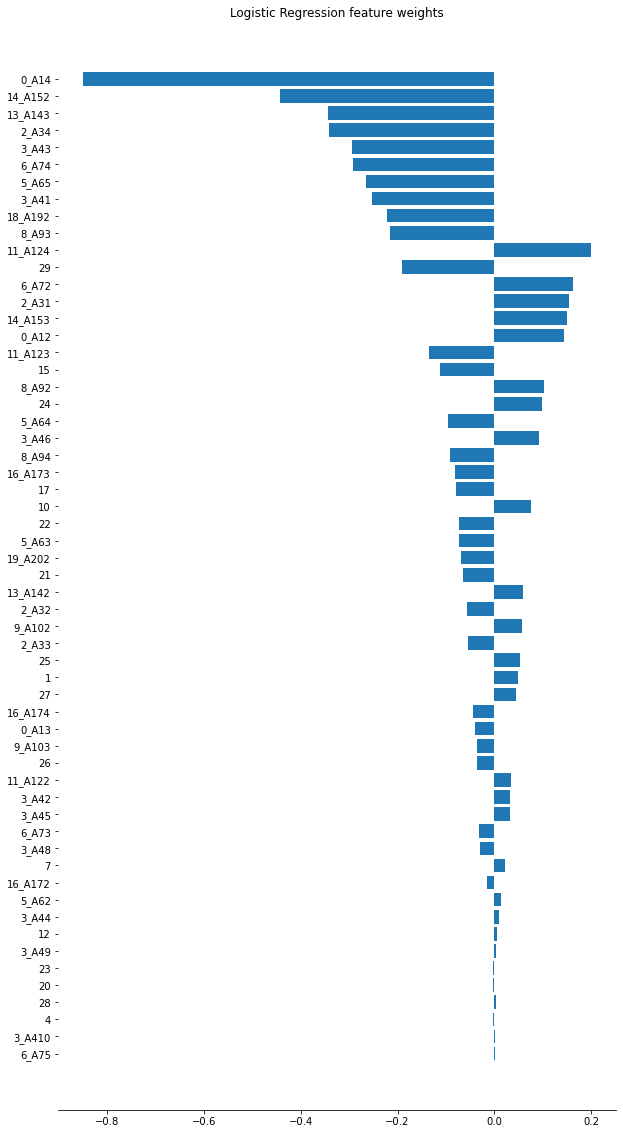

In [56]:
# plot feature weights

coefficients=lr.coef_[0].tolist()
names=X.columns.tolist()
showFeatures(names=names, coefficients=coefficients, title="Logistic Regression feature weights")

The weights could be affected by the scale of each variable, so we must scale them to see which ones are more important

### 2.3.3 Classification report

It is important to see if the accuracy is the same for both categories

In [119]:
print(classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       139
           1       0.51      0.36      0.42        61

    accuracy                           0.70       200
   macro avg       0.63      0.60      0.61       200
weighted avg       0.68      0.70      0.68       200



The precision, recall, f1-score are lower for the payment category

### 2.3.1.1 Removing correlated columns...

In [58]:
# do the same as before, but with the cleaned dataframe

with warnings.catch_warnings(record=True):
    non_corr_lr=LogisticRegression(random_state=SEED)
    non_corr_lr.fit(non_corr_X_train, non_corr_y_train)
    
non_corr_y_train_pred_lr=non_corr_lr.predict(non_corr_X_train)
non_corr_y_test_pred_lr=non_corr_lr.predict(non_corr_X_test)

print("Train accuracy score : {}".format(accuracy_score(non_corr_y_train, non_corr_y_train_pred_lr)))
print("Test accuracy score : {}".format(accuracy_score(non_corr_y_test, non_corr_y_test_pred_lr)))

Train accuracy score : 0.745
Test accuracy score : 0.715


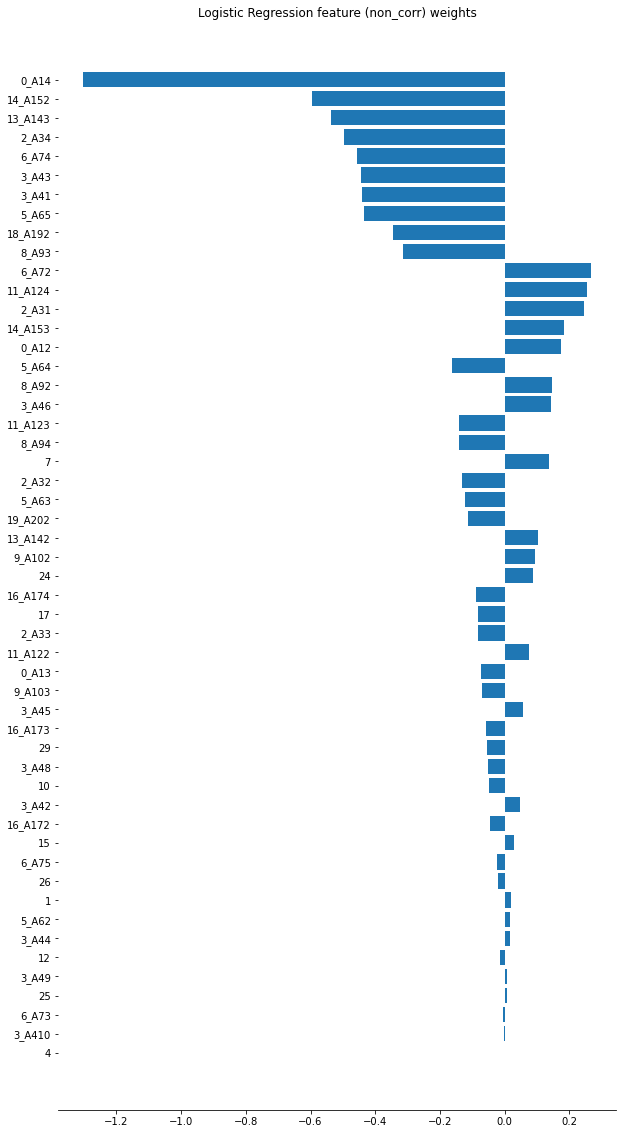

In [60]:
coefficients=non_corr_lr.coef_[0].tolist()
names=non_corr_X.columns.tolist()
showFeatures(names=names, coefficients=coefficients, title="Logistic Regression feature (non_corr) weights")

### 2.3.2 Scaled logit

In [55]:
# do the same but with the scaled dataframe

with warnings.catch_warnings(record=True):
    scaled_lr=LogisticRegression(random_state=SEED)
    scaled_lr.fit(scaled_X_train, scaled_y_train)
    
scaled_y_train_pred_lr=scaled_lr.predict(scaled_X_train)
scaled_y_test_pred_lr=scaled_lr.predict(scaled_X_test)

print("Train accuracy score : {}".format(accuracy_score(scaled_y_train, scaled_y_train_pred_lr)))
print("Test accuracy score : {}".format(accuracy_score(scaled_y_test, scaled_y_test_pred_lr)))

Train accuracy score : 0.78
Test accuracy score : 0.765


The accuracy is better in the train and test set, and the rates are similar! 

In [65]:
print(classification_report(scaled_y_test, scaled_y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       139
           1       0.63      0.54      0.58        61

    accuracy                           0.77       200
   macro avg       0.72      0.70      0.71       200
weighted avg       0.76      0.77      0.76       200



The precision, recall and f1-score improves in the payment category!

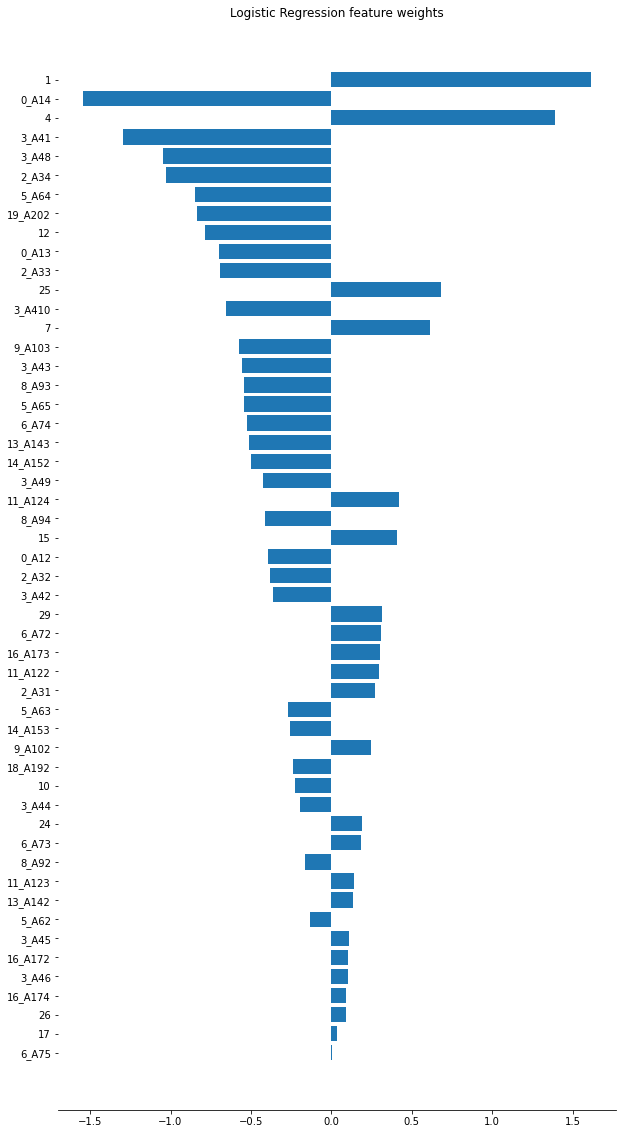

In [61]:
coefficients=scaled_lr.coef_[0].tolist()
names=scaled_X.columns.tolist()
showFeatures(names=names, coefficients=coefficients, title="Logistic Regression feature weights")

Now, other variables increased their weight.

### 2.3.2.1 Key features

The 5 largest weights are

- [x] The variable 1
- [x] The variable 0 category A14
- [x] The variable 4
- [x] The variable 3 category A41
- [x] The variable 3 category A48


In [211]:
# Stratified cross validation ... 
with warnings.catch_warnings(record=True):
    lr_cvScore=cross_val_score(scaled_lr, scaled_X, scaled_y)
    print(lr_cvScore)

[0.75  0.77  0.75  0.75  0.745]


- [x] Similar errors

#### 2.3.2.2 Too many variables. Regularization.

In this case we have more than 30 features, to make the model simple, we can try regularization

In [171]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold

# prepare param C to do a grid search

params={'C': np.linspace(0,1, num=50)}

grid_lr=LogisticRegression()

# define 5 splits for KFold cross validation

cv=KFold(n_splits=5)

gs=GridSearchCV(grid_lr, params, scoring='accuracy', cv=cv)

with warnings.catch_warnings(record=True):
    results=gs.fit(scaled_X, scaled_y)

    
# print bets params and score

print(results.best_params_)
print(results.best_score_)

{'C': 0.8163265306122448}
0.7510000000000001


In [179]:
coeffs=gs.best_estimator_.coef_

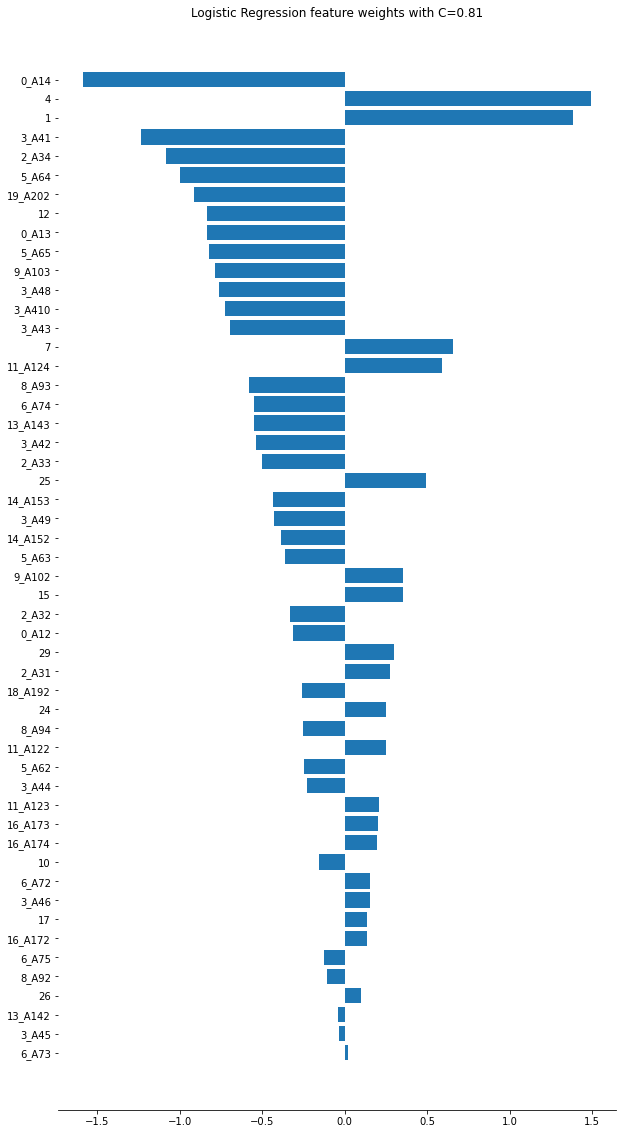

In [183]:
showFeatures(names=scaled_X.columns.tolist(), coefficients=coeffs[0], title="Logistic Regression feature weights with C=0.81")

0.72


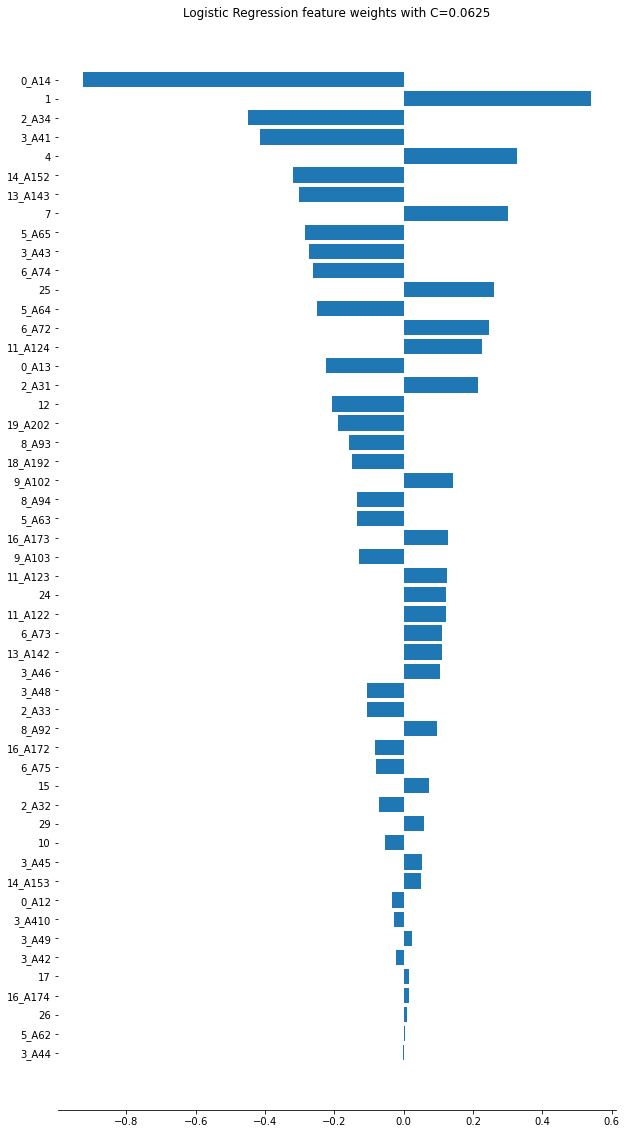

In [189]:
C=.0625
penalty_lr=LogisticRegression(C=C)

with warnings.catch_warnings(record=True):
    results=penalty_lr.fit(scaled_X_train, scaled_y_train)
    penalty_lr_y_pred=penalty_lr.predict(scaled_X_test)

print(accuracy_score(scaled_y_test, penalty_lr_y_pred))
showFeatures(names=scaled_X.columns.tolist(), coefficients=results.coef_[0], title=f"Logistic Regression feature weights with C={C}")

Using a C=0.0625 (lambda constant equal to 8), we get a model with 72% accuracy and less variables. And the most important variable is 0 with the category A14, followed by 1, 2_A34, 3_A41 and 4

In [190]:
with warnings.catch_warnings(record=True):
    penalty_lr_cvScore=cross_val_score(penalty_lr, scaled_X, scaled_y)
    print(penalty_lr_cvScore)

[0.725 0.72  0.75  0.705 0.74 ]


## 2.4 Probit Regression

The probit model is commonly used for default models in the bank industry!

In [79]:
from statsmodels.discrete.discrete_model import Probit

In [120]:
# Train probit model
pr=Probit(scaled_y_train, scaled_X_train)
pr_result=pr.fit()
print(pr_result.summary2())

         Current function value: 0.452803
         Iterations: 35
                             Results: Probit
Model:                  Probit             Pseudo R-squared:   0.257     
Dependent Variable:     30                 AIC:                822.4841  
Date:                   2022-11-02 14:55   BIC:                1052.0301 
No. Observations:       800                Log-Likelihood:     -362.24   
Df Model:               48                 LL-Null:            -487.84   
Df Residuals:           751                LLR p-value:        2.5358e-29
Converged:              0.0000             Scale:              1.0000    
No. Iterations:         35.0000                                          
-------------------------------------------------------------------------
         Coef.     Std.Err.      z    P>|z|      [0.025         0.975]   
-------------------------------------------------------------------------
1         9.7273      10.5070  0.9258 0.3546       -10.8661       30.3207
4

C:\Users\nicol\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [152]:
from scipy.stats import norm 

# predict probit on test set

coefs=pr_result.params
predictions=0
for column in scaled_X_test.columns:
    predictions+=coefs[column]*scaled_X_test[column]

norm_predictions=norm.cdf(predictions,0,1)
pr_y_pred=(norm_predictions>0.5)*1

print("Test accuracy {}".format(accuracy_score(scaled_y_test, pr_y_pred)))

Test accuracy 0.785


This accuracy is better than the logistic regression accuracy!

In [138]:
# predict probit on train set

train_predictions=0
for column in scaled_X_train.columns:
    train_predictions+=coefs[column]*scaled_X_train[column]

train_norm_predictions=norm.cdf(train_predictions,0,1)
pr_train_y_pred=(train_norm_predictions>0.5)*1

print("Train accuracy {}".format(accuracy_score(scaled_y_train, pr_train_y_pred)))

Train accuracy 0.78625


The test and train accuracy are similar. It is a good sign, let's do the last check (cross validation)

In [150]:
cv=KFold(n_splits=5)
accuracies=[]

with warnings.catch_warnings(record=True):
    for tr, tt in cv.split(scaled_X, scaled_y):
        cv_pr=Probit(scaled_y.filter(items=tr, axis=0), scaled_X.filter(items=tr, axis=0))
        cv_pr_result=pr.fit()

        predictions=0
        for column in scaled_X.columns:
            predictions+=coefs[column]*scaled_X.filter(items=tt, axis=0)[column]

        norm_predictions=norm.cdf(predictions,0,1)
        pr_y_pred=(norm_predictions>0.5)*1

        accuracies.append(accuracy_score(scaled_y.filter(items=tt, axis=0), pr_y_pred))


         Current function value: 0.452803
         Iterations: 35
         Current function value: 0.452803
         Iterations: 35
         Current function value: 0.452803
         Iterations: 35
         Current function value: 0.452803
         Iterations: 35
         Current function value: 0.452803
         Iterations: 35


In [151]:
print(accuracies)

[0.83, 0.81, 0.76, 0.735, 0.795]


The accuracies are slightly different depending on the train set...

In [154]:
# Classification report of test set

print(classification_report(scaled_y_test, pr_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       139
           1       0.65      0.64      0.64        61

    accuracy                           0.79       200
   macro avg       0.75      0.74      0.75       200
weighted avg       0.78      0.79      0.78       200



Precision, recall and f1-score are better than Logit model in the paid credits

### How to avoid overfitting

- [x] Use regularization, by making the model simplier 
- [x] Train with more data
- [x] Ensemble models (more than one, combined results)

# 3. Conclusions

- [x] Logit models have an accuracy of 75%, while probit models have better performance (better accuracy of 79%, better precision, recall and f1-score) but have little differences depending on the train set. Logit model seems to be better model due to generalization consistency.
- [x] The most important variables are the columns 0 (particularly the category A14 increases the probability of default), column 1 (lower values increase the probability of default), column 2 (particularly A34 increases the probability of default), column 3 (the category A41 increases the probability of default) and 4 (lower values increase the probability of default)

# 4. Just for fun

In this section I try without much deep the other models.

# 4.1 Decision Tree

In [247]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

dt=DecisionTreeClassifier(max_depth=6, random_state=SEED)
dt.fit(scaled_X_train, scaled_y_train)
y_pred=dt.predict(scaled_X_test)

accuracy_score(scaled_y_test, y_pred)

0.755

In [248]:
print(classification_report(scaled_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       139
           1       0.63      0.48      0.54        61

    accuracy                           0.76       200
   macro avg       0.71      0.68      0.69       200
weighted avg       0.74      0.76      0.74       200



Has the same problem with the precision for the paid category than the other models

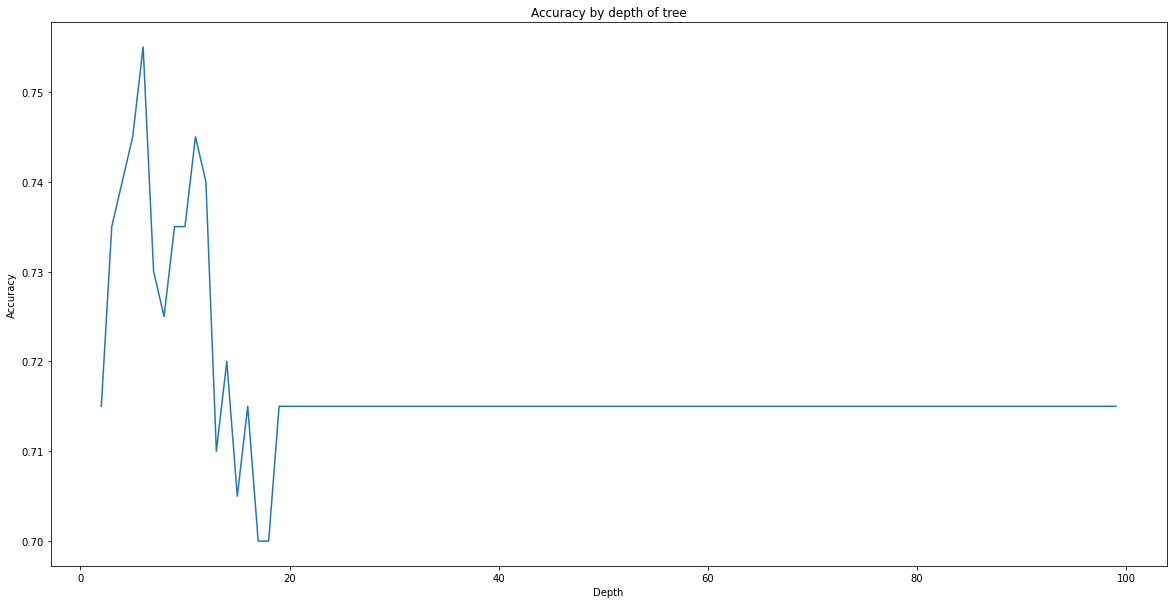

In [249]:
def testTree(depths=10):
    fig, ax=plt.subplots(figsize=(20,10))
    
    depths=[i for i in range(2,depths)]
    
    x=depths
    y=[]
    
    for depth in depths:
        
        dt=DecisionTreeClassifier(max_depth=depth, random_state=SEED)
        dt.fit(scaled_X_train, scaled_y_train)
        y_pred=dt.predict(scaled_X_test)

        accuracy=accuracy_score(scaled_y_test, y_pred)
        
        y.append(accuracy)
    
    ax.plot(x,y)
    
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy by depth of tree")
    ax.set_xlabel("Depth")
    return

testTree(depths=100)

Best accuracy is at depth of 6

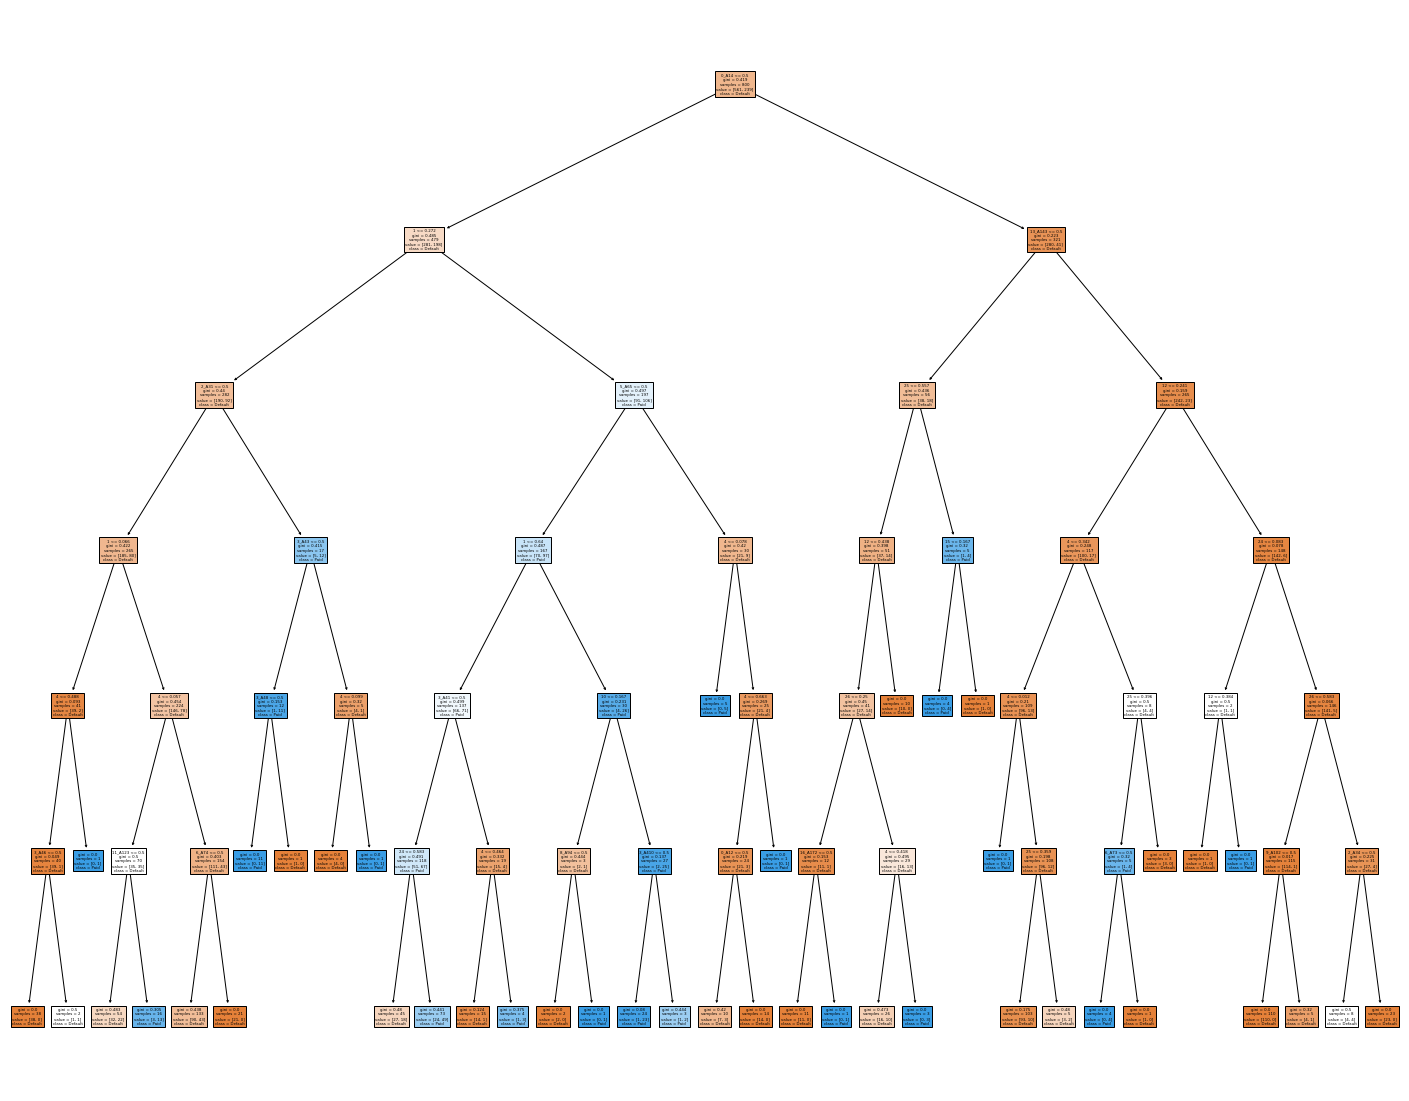

In [250]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt, feature_names=scaled_X_train.columns.tolist(),  class_names=["Default", "Paid"],
                   filled=True)
plt.show()

In [251]:
# Stratified cross validation ... 
with warnings.catch_warnings(record=True):
    dt_cvScore=cross_val_score(dt, scaled_X, scaled_y)
    print(dt_cvScore)

[0.705 0.74  0.655 0.715 0.705]


Note that accuracy is dependent on the train set. In the original it was 75%, in CV the min is 65%

In [252]:
# with less depth, depth of 3 we achieve...


dt=DecisionTreeClassifier(max_depth=3, random_state=SEED)
dt.fit(scaled_X_train, scaled_y_train)
y_pred=dt.predict(scaled_X_test)

accuracy_score(scaled_y_test, y_pred)

0.735

In [253]:
# Stratified cross validation ... 
with warnings.catch_warnings(record=True):
    dt_cvScore=cross_val_score(dt, scaled_X, scaled_y)
    print(dt_cvScore)

[0.74  0.69  0.71  0.695 0.69 ]


The results are better, less variance

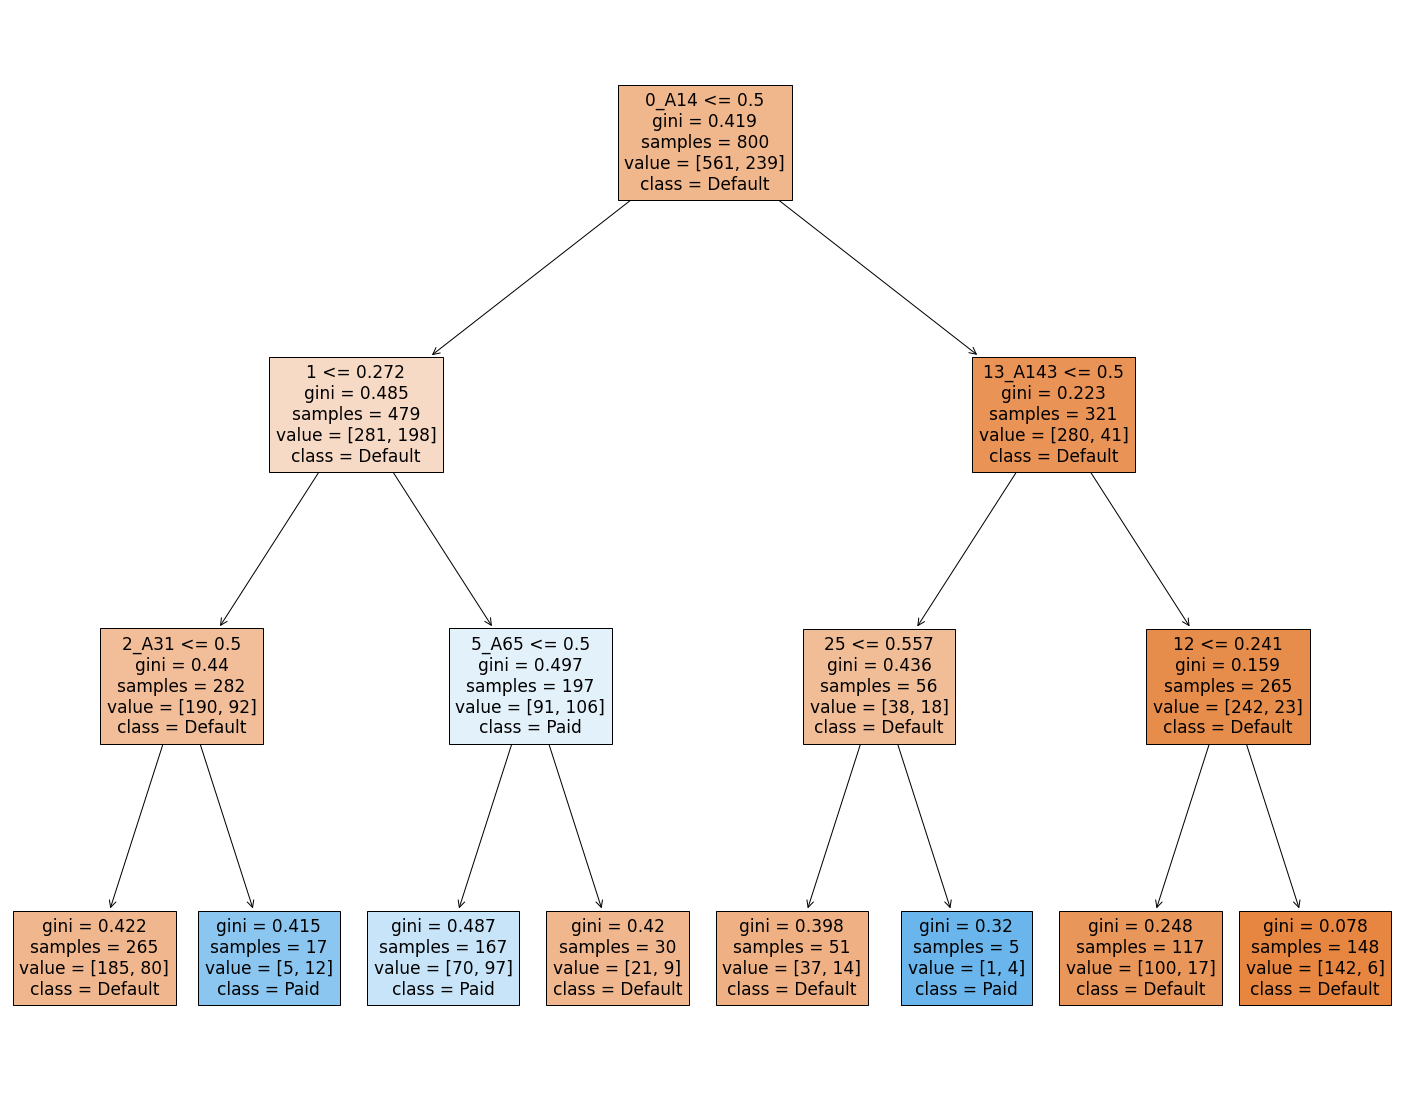

In [254]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt, feature_names=scaled_X_train.columns.tolist(),  class_names=["Default", "Paid"],
                   filled=True)
plt.show()

##### The behavior is similar to the other models, same key features.

# 4.2 K - Nearest Neighbors

It is also used for classification, uses similar customers to classify another one. 

In [265]:
from sklearn.neighbors import KNeighborsClassifier

kn=KNeighborsClassifier(n_neighbors=15)
kn.fit(scaled_X_train, scaled_y_train)
y_pred=kn.predict(scaled_X_test)
accuracy_score(scaled_y_test, y_pred)

0.755

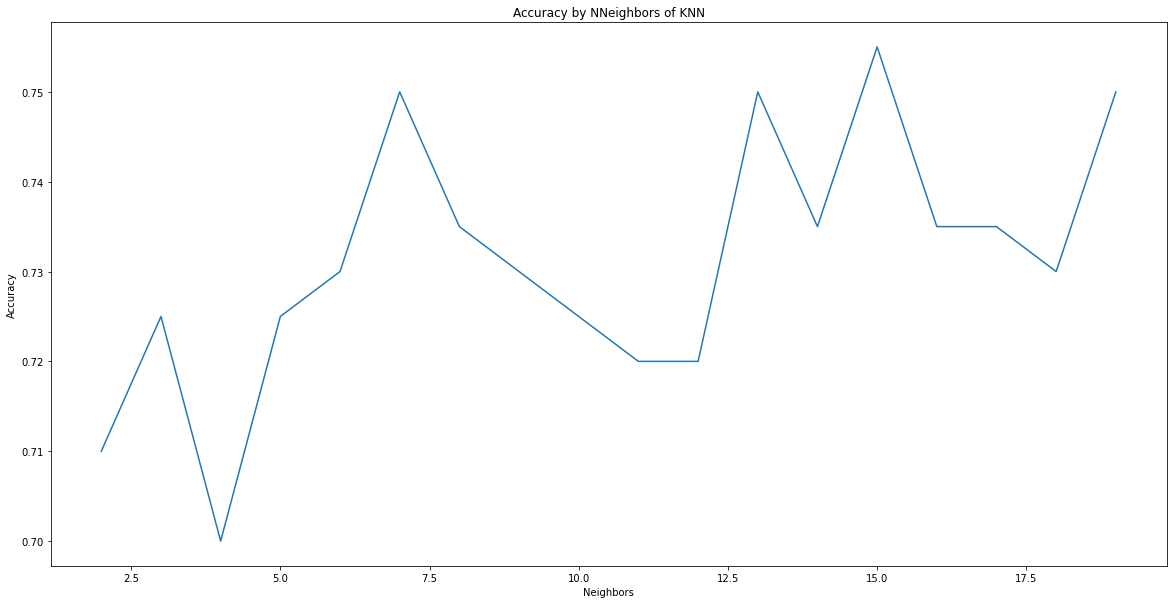

In [264]:
def testKNN(neighbors=10):
    fig, ax=plt.subplots(figsize=(20,10))
    
    neighbors=[i for i in range(2,neighbors)]
    
    x=neighbors
    y=[]
    
    for neighbor in neighbors:
        
        kn=KNeighborsClassifier(n_neighbors=neighbor)
        kn.fit(scaled_X_train, scaled_y_train)
        y_pred=kn.predict(scaled_X_test)
        
        accuracy=accuracy_score(scaled_y_test, y_pred)
        
        y.append(accuracy)
    
    ax.plot(x,y)
    
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy by NNeighbors of KNN")
    ax.set_xlabel("Neighbors")
    return

testKNN(neighbors=20)

The best accuracy is reached in 15 neighbors

In [267]:
print(classification_report(scaled_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84       139
           1       0.73      0.31      0.44        61

    accuracy                           0.76       200
   macro avg       0.74      0.63      0.64       200
weighted avg       0.75      0.76      0.72       200



Surprisingly the precision is similar for both categories!, but for the recall and f1-score is not the same :/

In [268]:
# Stratified cross validation ... 
with warnings.catch_warnings(record=True):
    kn_cvScore=cross_val_score(kn, scaled_X, scaled_y)
    print(kn_cvScore)

[0.695 0.67  0.705 0.705 0.68 ]


Min is 67%, while the test accuracy is 76%